<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/main/Class_02_3_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

##### **Module 2: Neural Networks with Tensorflow and Keras**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Biology, Health and the Environment](https://sciences.utsa.edu/bhe/), [UTSA](https://www.utsa.edu/)

### Module 2 Material

* Part 2.1: Introduction to Neural Networks with PyTorch
* Part 2.2: Encoding Feature Vectors
* **Part 2.3: Controlling Overfitting**
* Part 2.4: Saving and Loading a PyTorch Neural Network

## Google CoLab Instructions

You MUST run the following code cell to get credit for this class lesson. By running this code cell, you will map your GDrive to /content/drive and print out your Google GMAIL address. Your Instructor will use your GMAIL address to verify the author of this class lesson.

In [1]:
# You must run this cell first
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from google.colab import auth
    auth.authenticate_user()
    Colab = True
    print("Note: Using Google CoLab")
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
    print(gcloud_tokeninfo['email'])
except:
    print("**WARNING**: Your GMAIL address was **not** printed in the output below.")
    print("**WARNING**: You will NOT receive credit for this lesson.")
    Colab = False

Mounted at /content/drive
Note: Using Google CoLab
david.senseman@gmail.com


You should see the following output except your GMAIL address should appear on the last line.

![__](https://biologicslab.co/BIO1173/images/class_01/class_01_6_image01A.png)

If your GMAIL address does not appear your lesson will **not** be graded.

### Create Custom Function

Run the cell below to create a function that will be needed later in this lesson.

In [2]:
# Simple function to print out elasped time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

If the code is correct you should not see any output.

## **Data Sets for this Lesson**

For this lesson, the **Obesity Data Set** will be used for the Examples and the **Heart Disease Data Set** will be used for the **Exercises**. Information about the Heart Disease Data set was presented in the previous lesson. Here is the information about the Obesity Data set.

### **Obesity Data Set**

![___](https://biologicslab.co/BIO1173/images/obesity.jpg)

[Obesity Data Set](https://archive.ics.uci.edu/ml/datasets/)

**Description:**

The **Obesity Data Set** includes data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. The data contains 17 attributes and 2111 records, the records are labeled with the class variable NObesity (Obesity Level), that allows classification of the data using the values of `Insufficient Weight`, `Normal Weight`, `Overweight Level I`, `Overweight Level II`, `Obesity Type I`, `Obesity Type II` and `Obesity Type III`.

**Key Features:**

* **Gender-** Female/Male
* **Age-** Numeric value
* **Height-** Numeric value in meters
* **Weight-** Numeric value in kilograms
* **family_history_with_overweight-** Has a family member suffered or suffers from overweight - Yes/No
* **FAVC-** Do you eat high caloric food frequently - Yes/No
* **FCVC-** Do you usually eat vegetables in your meals - Never/Sometimes/Always
* **NCP-** How many main meals do you have daily - Between 1 y 2/Three/More than three
* **CAEC-** Do you eat any food between meals? - No/Sometimes/Frequently/Always
* **SMOKE-** Do you smoke? - Yes/No
* **CH2O-** How much water do you drink daily? - Less than a liter/Between 1 and 2 L/More than 2 L
* **SCC-** Do you monitor the calories you eat daily - Yes/No
* **FAF-** How often do you have physical activity? - I do not have/1 or 2 days/2 or 4 days/4 or 5 days
* **TUE-** How much time do you use technological devices such as cell phone, videogames, television, computer and others - 0–2 hours/3–5 hours/More than 5 hours
* **CALC-** How often do you drink alcohol? - I do not drink/Sometimes/Frequently/Always
* **MTRANS-** Which transportation do you usually use? Automobile/Motorbike/Bike/Public Transportation/Walking
* **NObeyesdad-** Obesity levels: 'Insufficient_Weight', 'Obesity_Type_III', 'Normal_Weight', 'Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_I', 'Overweight_Level_II'

For our classification neural network (`ob_model`), the response variable (`Y`) will be the column `NObeyesdad`. This column contains 7 categorical variables shown here sorted from lowest to highest obesity:

* Insufficient_Weight
* Normal_Weight
* Overweight_Level_I
* Overweight_Level_II
* Obesity_Type_I  
* Obesity_Type_II
* Obesity_Type_III


----------------------------------------------

# **The Problem of `Overfitting`**

When a neural network learns a task, it adjusts its parameters so that the error on the training data decreases.

However, it can be quite easy for the model to becomes **too good** at reproducing the training sample by **memorizing idiosyncratic noise** instead of capturing the true underlying relationship. This situation is called **overfitting**.

#### **How `Overfitting` Happens**

* **Too many trainable parameters:**
A very deep or wide network can represent a vast space of functions.
With few training examples, the model can fit every detail, including random fluctuations.

* **Insufficient or unrepresentative data:**
If the training set does not cover the variability of the problem domain, the model learns patterns that only exist in the training data.

* **Training for too many epochs:**
Continuing the optimisation past the point where validation error stops decreasing lets the network fine‑tune to noise.

* **Lack of regularisation:**
No constraints on weights, activations or hidden‑layer outputs allow the model to swing wildly to minimise the training loss.

#### **Why `Overfitting` is Bad**

* **Poor generalisation:**
The model's predictions on new data (test set, real-world inputs) are much worse than its performance on the training set.

* **Misleading confidence:**
An overfitted network often reports low loss or high accuracy, giving a false sense of reliability.

* **Wasted resources:**
Training longer or with more complex architectures is unnecessary when the model will not perform better on unseen data.

* **Deployment risks:**
In safety-critical applications (self-driving cars, medical diagnosis), an overfitted model can produce dangerous errors.

## **Controlling `Overfitting`**

This lesson focuses on how you can control overfitting during the training of neural networks. Here are the 3 common strategies that are typically used to deal with the issues related to overfitting:

* **`Early Stopping`**
* **`L1/L2 Regularization`**
* **`Dropout` Layers**

To illustrate the strengths and weaknesses of each strategy, this lesson will use four Examples and four companion **Exercises**.

1. `Example 1`/**`Exercise 1`**: A classification neural network will be trained _without_ any measures to prevent overfitting. This will serve as a **baseline** against which to judge the remaining Examples and **Exercises**.
2. `Example 2`/**`Exercise 2`**: Exactly the same neural network will be trained using **`EarlyStopping`** to control overfitting.
3. `Example 3`/**`Exercise 3`**: Instead of EarlyStopping, the technique of **`L1 Regularization`** will be used to limit overfitting.
4. `Example 4`/**`Exercise 4`**: Finally, the technique of adding **`Dropout`** layers will be used to limit overfitting.

It should be noted that there is no technical reason to use only a single technique to limit overfitting -- two (or more) strategies are often used in combination depending upon the particular situation.

### Example 1A: Neural Network Training: No Overfitting Prevention

In earlier lessons the training of neural networks was divided into a series of smaller steps to help students master the underlying programming concepts. The code in the cell below, however, provides a **_all_**  the code in a single block needed to:
1. read and preparing the tabular data
2. build and compile a classification neural network
3. train the neural network.

With a few minor but notable exceptions, **exactly** this same code block will be used for all 4 Examples as well as for their corresponding **Exercises**.

While a detailed explanation of the different code chucks will not be provided, here are a few key points.

1. The following code chunk reads the `Obesity Data Set` from the course web server and stores it in a DataFrame called `ob_df`.
```text
# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
ob_df = pd.read_csv("https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
                    na_values=['NA','?'])

```
You will of course have to modify this line of code to read the Heart Disease data set for **`Exercise 1`**.

2. The **target column** (Y-values) for the classification is the column called

```text
# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
ob_target_col = "NObeyesdad"
```
This column contains 7-levels of obesity encoded as strings:
* Insufficient_Weight
* Normal_Weight
* Overweight_Level_I
* Overweight_Level_II
* Obesity_Type_I
* Obesity_Type_II
* Obesity_Type_III

These string values will be automatically `one-hot encoded` as part of the data preparation code.
```text
le = LabelEncoder()
ob_df[ob_target_col] = le.fit_transform(ob_df[ob_target_col])
```

**Code Hints:**

It should be noted that within the code block

 `7️⃣  Callbacks (monitor accuracy)`

the following code is included to implement **`EarlyStopping`**
```text
callbacks = [
    EarlyStopping(monitor="val_accuracy",
                  patience=PATIENCE,
                  restore_best_weights=True),
```
However, **`EarlyStopping`** is not implemented in `Example 1` due to the fact that during training, the line that would normally invoke the `EarlyStopping callback` has been "commented-out: by placing a `#` in front of the line:
```text
# Train (fit)
ob_history = ob_model.fit(
    ob_X_train_proc, ob_y_train,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=(ob_X_val_proc, ob_y_val),
    #callbacks=callbacks,  # Prevent EarlyStopping
    verbose=VERBOSE
)
```
So even though the code for `EarlyStopping` is included within the complete code block, it will not be used since this line has been commented out.

You should also note that the variable **`VERSBOSE`** has been set to `0` which means there will be not output during training. This has been done to help keep the length of you Colab PDF a more reasonable value.

In [14]:
# Example 1A: Neural Network Training: No Overfitting Prevention (PyTorch Version)

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 0     # 0 means no output during training
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function for timing (if not already defined in your notebook)
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
ob_df = pd.read_csv("https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
                    na_values=['NA','?'])

# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
ob_target_col = "NObeyesdad"
le = LabelEncoder()
ob_df[ob_target_col] = le.fit_transform(ob_df[ob_target_col])

ob_X = ob_df.drop(columns=[ob_target_col])
ob_y = ob_df[ob_target_col].astype('int32')

# ------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# ------------------------------------------------------------
# First split into train+val and test
ob_X_temp, ob_X_test, ob_y_temp, ob_y_test = train_test_split(
    ob_X, ob_y, test_size=0.2, random_state=42, stratify=ob_y)

# Then split train+val into train and val
ob_X_train, ob_X_val, ob_y_train, ob_y_val = train_test_split(
    ob_X_temp, ob_y_temp, test_size=0.1, random_state=42, stratify=ob_y_temp)

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------
categorical_cols = [c for c in ob_X.columns if ob_X[c].dtype == "object"]
numeric_cols     = [c for c in ob_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Convert data to correct numeric type (Numpy arrays)
ob_X_train_proc = preprocessor.fit_transform(ob_X_train).astype(np.float32)
ob_X_val_proc   = preprocessor.transform(ob_X_val).astype(np.float32)
ob_X_test_proc  = preprocessor.transform(ob_X_test).astype(np.float32)

ob_y_train = ob_y_train.to_numpy().astype(np.int32).reshape(-1)
ob_y_val   = ob_y_val.to_numpy().astype(np.int32).reshape(-1)
ob_y_test  = ob_y_test.to_numpy().astype(np.int32).reshape(-1)

# ------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# ------------------------------------------------------------
# Convert Features to Float Tensors
ob_X_train_t = torch.tensor(ob_X_train_proc).to(device)
ob_X_val_t   = torch.tensor(ob_X_val_proc).to(device)
ob_X_test_t  = torch.tensor(ob_X_test_proc).to(device)

# Convert Targets to Long Tensors (Required for CrossEntropyLoss)
ob_y_train_t = torch.tensor(ob_y_train, dtype=torch.long).to(device)
ob_y_val_t   = torch.tensor(ob_y_val, dtype=torch.long).to(device)
ob_y_test_t  = torch.tensor(ob_y_test, dtype=torch.long).to(device)

# Create DataLoaders for batching
ob_train_dataset = TensorDataset(ob_X_train_t, ob_y_train_t)
ob_val_dataset   = TensorDataset(ob_X_val_t, ob_y_val_t)

ob_train_loader = DataLoader(ob_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ob_val_loader   = DataLoader(ob_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------------------------------------------
# 7️⃣  Build Model & Optimizer
# ------------------------------------------------------------
n_classes = len(np.unique(ob_y_train))
input_dim = ob_X_train_proc.shape[1]

# Define PyTorch Model
class ObesityNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, output_dim)
        # Note: No Softmax here. CrossEntropyLoss expects raw logits.

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

ob_model = ObesityNet(input_dim, n_classes).to(device)

# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ob_model.parameters(), lr=LEARNING_RATE)

# ------------------------------------------------------------
# 8️⃣  Train model (Manual Loop)
# ------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

# Dictionary to store history (similar to Keras history object)
ob_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    ob_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in ob_train_loader:
        optimizer.zero_grad()               # Reset gradients
        outputs = ob_model(X_batch)         # Forward pass
        loss = loss_fn(outputs, y_batch)    # Calculate loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(ob_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    ob_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): # No gradient needed for validation
        for X_batch, y_batch in ob_val_loader:
            outputs = ob_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(ob_val_loader)
    val_acc = correct / total

    # Store metrics
    ob_history['accuracy'].append(train_acc)
    ob_history['val_accuracy'].append(val_acc)
    ob_history['loss'].append(avg_train_loss)
    ob_history['val_loss'].append(avg_val_loss)

    # Verbose print (optional simulation of Keras verbose=1)
    if VERBOSE == 1:
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}")


# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(ob_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.9822485207100592
Elapsed time: 0:00:06.45


If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image22C.png)

Our `ob_model` neural network appears to done a great job since the best validation accuracy (`val accuracy`) is above 95%. However, let's examine the model's training accuracy more carefully in `Example 1B` below.


### Example 1B: Visualize Effects of No Overfitting Prevention

After training we can assess its efficacy by visualizing two training curves —specifically **train loss vs. validation loss** and **train accuracy vs. validation accuracy**.

Inspection of these curves can tell us if overfitting has occurred during training. Specifically, if training loss keeps decreasing while validation loss starts increasing, the model is likely **overfitting**—memorizing training data rather than learning general patterns. Similarly, if **training accuracy increases** but **validation accuracy plateaus or drops**, it's another sign of overfitting.

This code in the cell below was introduced in a previous lesson. It uses the `matplotlib.pyplot` graphics library to generate the two plots.

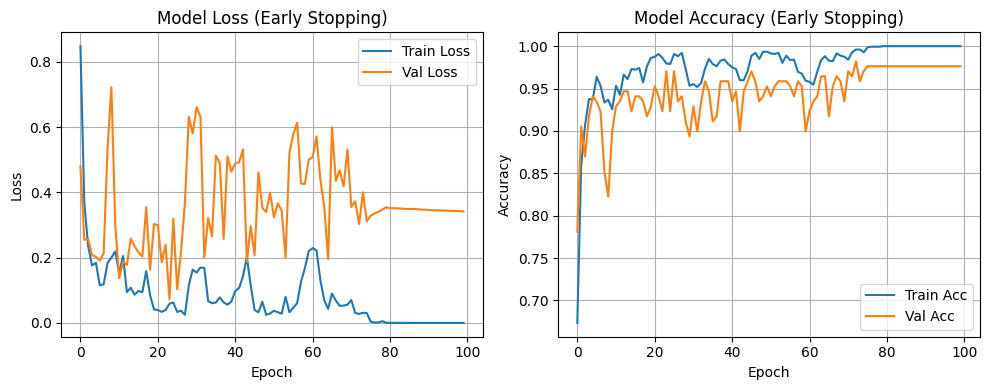

In [15]:
# Example 1B: Visualize effects of Early Stopping (PyTorch Version)

import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(ob_history['loss'], label='Train Loss')
ax1.plot(ob_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Early Stopping)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(ob_history['accuracy'], label='Train Acc')
ax2.plot(ob_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Early Stopping)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image23C.png)

There can be considerable variability in these plots from one run to the next.

### **Analysis**

While your plots will probably look rather different, the two plots shown in the example above clearly illustrate that **overfitting** occurred during training. Here's a breakdown of the interpretation:

#### **Loss Plot (Top)**
* **Training Loss (blue):** Decreases steadily and approaches zero, indicating the model is learning the training data very well.
* **Validation Loss (orange):** Starts off decreasing but then fluctuates and remains significantly higher than the training loss, suggesting the model is not generalizing well to unseen data.

#### **Accuracy Plot (Bottom)**
* **Training Accuracy (blue):** Increases to nearly 100%, showing the model is fitting the training data extremely well.
* **Validation Accuracy (orange):** Shows fluctuations and plateaus at a lower level than training accuracy, reinforcing the idea that the model is not performing well on validation data.

#### **Conclusion**
This behavior is typical of a model that is memorizing the training data rather than learning generalizable patterns.

### **Exercise 1A: Classification Neural Network: No Overfitting Prevention**

In the cell below write the code to to build, compile and train a classification neural network called `hd_model`. As usual, start by copying all of `Example 1` into the cell below.

Since you will be using the Heart Disease dataset for all of the **`Exercises`**, use this code chunk to read your dataset from the course file server and create a DataFrame called `hd_df`.
```text
# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
hd_df = pd.read_csv("https://biologicslab.co/BIO1173/data/heart_disease.csv",
                    na_values=['NA','?'])

```

Your objective is to predict the kind of `Resting ECG` a patient will likely display given his/her other clinical measurements. Therefore the data in the column `RestingECG` will be your `Y-values` and the data in the other columns will be your `X-values`. Since your target column has 3 classes: `Normal`, `ST` and `LVH`, you will be training your neural network (`hd_model`) to predict which of type of Resting ECG a particular patient will likely have given his/her other clinical measurements (`X-values`).

You will therefore need to specify your target column as follows:
```text
hd_target_col = "RestingECG"
```

**Code Hints:**

Change the prefix `ob_` to `hd_` everywhere in the code copied from Example 1.

In [16]:
# Exercise 1A: Neural Network Training (Heart Disease) - No Overfitting Prevention (PyTorch)

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 0     # 0 means no output during training
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function for timing
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
hd_df = pd.read_csv("https://biologicslab.co/BIO1173/data/heart_disease.csv",
                    na_values=['NA','?'])

# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
hd_target_col = "RestingECG"  # Target: Normal, ST, or LVH
le = LabelEncoder()
hd_df[hd_target_col] = le.fit_transform(hd_df[hd_target_col])

hd_X = hd_df.drop(columns=[hd_target_col])
hd_y = hd_df[hd_target_col].astype('int32')

# ------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# ------------------------------------------------------------
# First split into train+val and test
hd_X_temp, hd_X_test, hd_y_temp, hd_y_test = train_test_split(
    hd_X, hd_y, test_size=0.2, random_state=42, stratify=hd_y)

# Then split train+val into train and val
hd_X_train, hd_X_val, hd_y_train, hd_y_val = train_test_split(
    hd_X_temp, hd_y_temp, test_size=0.1, random_state=42, stratify=hd_y_temp)

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------
categorical_cols = [c for c in hd_X.columns if hd_X[c].dtype == "object"]
numeric_cols     = [c for c in hd_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Convert data to correct numeric type (Numpy arrays)
hd_X_train_proc = preprocessor.fit_transform(hd_X_train).astype(np.float32)
hd_X_val_proc   = preprocessor.transform(hd_X_val).astype(np.float32)
hd_X_test_proc  = preprocessor.transform(hd_X_test).astype(np.float32)

hd_y_train = hd_y_train.to_numpy().astype(np.int32).reshape(-1)
hd_y_val   = hd_y_val.to_numpy().astype(np.int32).reshape(-1)
hd_y_test  = hd_y_test.to_numpy().astype(np.int32).reshape(-1)

# ------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# ------------------------------------------------------------
# Convert Features to Float Tensors
hd_X_train_t = torch.tensor(hd_X_train_proc).to(device)
hd_X_val_t   = torch.tensor(hd_X_val_proc).to(device)
hd_X_test_t  = torch.tensor(hd_X_test_proc).to(device)

# Convert Targets to Long Tensors
hd_y_train_t = torch.tensor(hd_y_train, dtype=torch.long).to(device)
hd_y_val_t   = torch.tensor(hd_y_val, dtype=torch.long).to(device)
hd_y_test_t  = torch.tensor(hd_y_test, dtype=torch.long).to(device)

# Create DataLoaders
hd_train_dataset = TensorDataset(hd_X_train_t, hd_y_train_t)
hd_val_dataset   = TensorDataset(hd_X_val_t, hd_y_val_t)

hd_train_loader = DataLoader(hd_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
hd_val_loader   = DataLoader(hd_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------------------------------------------
# 7️⃣  Build Model & Optimizer
# ------------------------------------------------------------
n_classes = len(np.unique(hd_y_train))
input_dim = hd_X_train_proc.shape[1]

# Define PyTorch Model
class HeartDiseaseNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HeartDiseaseNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

hd_model = HeartDiseaseNet(input_dim, n_classes).to(device)

# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(hd_model.parameters(), lr=LEARNING_RATE)

# ------------------------------------------------------------
# 8️⃣  Train model
# ------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

hd_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    hd_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in hd_train_loader:
        optimizer.zero_grad()
        outputs = hd_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(hd_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    hd_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in hd_val_loader:
            outputs = hd_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(hd_val_loader)
    val_acc = correct / total

    # Store metrics
    hd_history['accuracy'].append(train_acc)
    hd_history['val_accuracy'].append(val_acc)
    hd_history['loss'].append(avg_train_loss)
    hd_history['val_loss'].append(avg_val_loss)

    if VERBOSE == 1:
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}")

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(hd_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6216216216216216
Elapsed time: 0:00:03.06


If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image25C.png)


### **Exercise 1B: Visualize Effects of No Overfitting Prevention**

In the cell below write the code to visualize your training by creating a  **train loss vs. validation loss** plot and **train accuracy vs. validation accuracy** plot.

**Code Hints:**

Your `history` object should be called `hd_history` instead of `ob_history`.

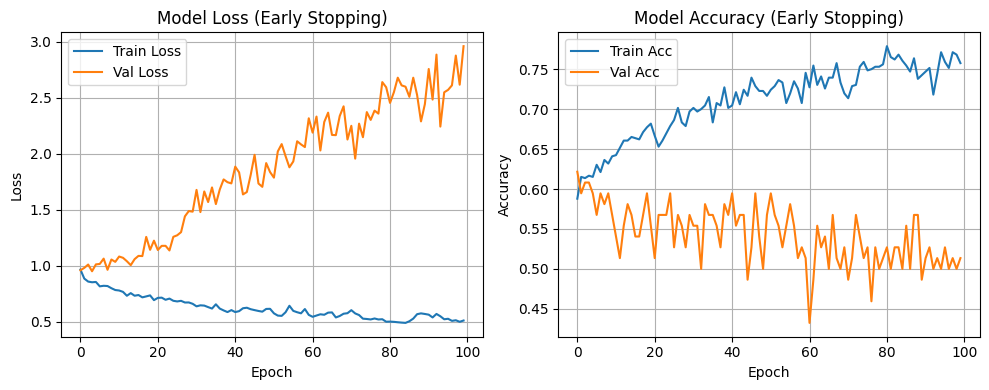

In [17]:
# Insert your code for Exercise 1B here

import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(hd_history['loss'], label='Train Loss')
ax1.plot(hd_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Early Stopping)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(hd_history['accuracy'], label='Train Acc')
ax2.plot(hd_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Early Stopping)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image26C.png)

### **Analysis**

An analysis of the two plots shown in the example above, again show clear signs of **overfitting** in your classification neural network. Here's a detailed interpretation:

#### **Loss Plot (Top)**
* **Training Loss (blue):** Gradually decreases over time, indicating the model is learning the training data well.
* **Validation Loss (orange):** Initially decreases but then starts increasing significantly after around **epoch 20**, which is a classic sign of **overfitting**. The model begins to **memorize the training data** and loses generalization ability.

#### **Accuracy Plot (Bottom)**
* **Training Accuracy (blue):** Rapidly reaches near-perfect accuracy and stays high, showing the model is fitting the training data extremely well.
* **Validation Accuracy (orange):** Increases initially but plateaus and remains lower than training accuracy, further confirming that the model is not generalizing well.

#### **Overall Interpretation**
* The model is overfitting after about **20 epochs**.
* This is likely due to the lack of regularization techniques such as:
* * EarlyStopping (to halt training when validation loss starts increasing),
* * Dropout layers (to reduce reliance on specific neurons),
* * L1/L2 Regularization (to penalize overly complex models).

# **Early Stopping in Keras to Prevent Overfitting**

Now that we have established baselines in `Exmaple 1` and in **`Exercise 1`** that **overfitting** occurs, we will now examine techniques that can be used to control overfitting. In `Example 2` will look at **`EarlyStopping`**.

It can be difficult to determine how many epochs to cycle through to optimally train a neural network. **_Overfitting_** will occur if you train the neural network for too many epochs, and the neural network will not perform well on **new data**, despite attaining a good accuracy on the training set.

Overfitting occurs when a neural network is trained to the point that it begins to **memorize rather than generalize**, as demonstrated in this figure.


![Training vs. Validation Error for Overfitting](https://biologicslab.co/BIO1173/images/class_02/class_3_training_val.png "Training vs. Validation Error for Overfitting")
**Training vs. Validation Error for Overfitting**

It is important to segment the original dataset into several datasets:

* **Training Set**
* **Validation Set**
* **Holdout Set**

You can construct these sets in several different ways. The following programs demonstrate some of these.

The first method is a **`training`** and **`validation set`**. We use the `training data` to train the neural network until the `validation set` no longer improves. This attempts to stop at a near-optimal training point.

This method will only give accurate "out of sample" predictions for the `validation set`; this is usually 20% of the data. The predictions for the training data will be overly optimistic, as these were the data that we used to train the neural network.

This figure demonstrates how we divide the dataset.

![Training with a Validation Set](https://biologicslab.co/BIO1173/images/class_02/class_1_train_val.png "Training with a Validation Set")

**Training with a Validation Set**

### Example 2A: Neural Network Training: Overfitting Prevention with `EarlyStopping`

As mentioned above, `Example 1` contained all of the code to implement **`EarlyStopping`** in section 7:
```text
# ------------------------------------------------------------
# 7️⃣  Callbacks (monitor accuracy)
# ------------------------------------------------------------
checkpoint_path = "ob_best_classification_model.keras"
callbacks = [
    EarlyStopping(monitor="val_accuracy",
                  patience=PATIENCE,
                  restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path,
                    monitor="val_accuracy",
                    save_best_only=True),
    ReduceLROnPlateau(monitor="val_accuracy",
                      factor=0.5,
                      patience=int(PATIENCE/2),
                      verbose=0)
]
```
As you can see, the `EarlyStopping` is "monitoring" the values of **validation accuracy (val_accuracy)**. Since the variable **PATIENCE** is set to `10` the EarlyStopping monitor will wait for `10` Epochs for the `val_accuracy` to improve after reaching a maximum before terminating the training run.

Here is the code chunk that controls the training
```text
ob_history = ob_model.fit(
    ob_X_train_proc, ob_y_train,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=(ob_X_val_proc, ob_y_val),
    callbacks=callbacks,
    verbose=VERBOSE
)
```
Notice that that the next to the last line:
```text
callbacks=callbacks,
```
allows the `EarlyStopping monitor` to exert control over the training cycle. In `Example 2` the `#` has been removed to allow `EarlyStopping` to be implemented. The only other change in the code from `Example 1` has been to set the `VERBOSE` variable to `2` so we can watch the training output.
```text
VERBOSE       = 2
```

In [18]:
# Example 2A: Neural Network Training: Overfitting Prevention with Early Stopping (PyTorch Version)

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 2     # Set to 1 or 2 to see training progress
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function for timing
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
ob_df = pd.read_csv("https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
                    na_values=['NA','?'])

# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
ob_target_col = "NObeyesdad"
le = LabelEncoder()
ob_df[ob_target_col] = le.fit_transform(ob_df[ob_target_col])

ob_X = ob_df.drop(columns=[ob_target_col])
ob_y = ob_df[ob_target_col].astype('int32')

# ------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# ------------------------------------------------------------
# First split into train+val and test
ob_X_temp, ob_X_test, ob_y_temp, ob_y_test = train_test_split(
    ob_X, ob_y, test_size=0.2, random_state=42, stratify=ob_y)

# Then split train+val into train and val
ob_X_train, ob_X_val, ob_y_train, ob_y_val = train_test_split(
    ob_X_temp, ob_y_temp, test_size=0.1, random_state=42, stratify=ob_y_temp)

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------
categorical_cols = [c for c in ob_X.columns if ob_X[c].dtype == "object"]
numeric_cols     = [c for c in ob_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Convert data to correct numeric type (Numpy arrays)
ob_X_train_proc = preprocessor.fit_transform(ob_X_train).astype(np.float32)
ob_X_val_proc   = preprocessor.transform(ob_X_val).astype(np.float32)
ob_X_test_proc  = preprocessor.transform(ob_X_test).astype(np.float32)

ob_y_train = ob_y_train.to_numpy().astype(np.int32).reshape(-1)
ob_y_val   = ob_y_val.to_numpy().astype(np.int32).reshape(-1)
ob_y_test  = ob_y_test.to_numpy().astype(np.int32).reshape(-1)

# ------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# ------------------------------------------------------------
ob_X_train_t = torch.tensor(ob_X_train_proc).to(device)
ob_X_val_t   = torch.tensor(ob_X_val_proc).to(device)
ob_X_test_t  = torch.tensor(ob_X_test_proc).to(device)

ob_y_train_t = torch.tensor(ob_y_train, dtype=torch.long).to(device)
ob_y_val_t   = torch.tensor(ob_y_val, dtype=torch.long).to(device)
ob_y_test_t  = torch.tensor(ob_y_test, dtype=torch.long).to(device)

ob_train_dataset = TensorDataset(ob_X_train_t, ob_y_train_t)
ob_val_dataset   = TensorDataset(ob_X_val_t, ob_y_val_t)

ob_train_loader = DataLoader(ob_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ob_val_loader   = DataLoader(ob_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------------------------------------------
# 7️⃣  Build Model, Optimizer & Scheduler
# ------------------------------------------------------------
n_classes = len(np.unique(ob_y_train))
input_dim = ob_X_train_proc.shape[1]

class ObesityNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

ob_model = ObesityNet(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ob_model.parameters(), lr=LEARNING_RATE)

# ReduceLROnPlateau Scheduler
# mode='max' because we want to maximize 'val_accuracy'
# FIX: Removed 'verbose=True' causing the error
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                 factor=0.5,
                                                 patience=int(PATIENCE/2))

# ------------------------------------------------------------
# 8️⃣  Train model with Early Stopping
# ------------------------------------------------------------
print(f"-----Training Starting for up to {EPOCHS} epochs --------------------------")
start_time = time.time()

ob_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

# Variables for Early Stopping
best_val_acc = 0.0
patience_counter = 0
checkpoint_path = "ob_best_classification_model.pth"

for epoch in range(EPOCHS):
    # --- Training Phase ---
    ob_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in ob_train_loader:
        optimizer.zero_grad()
        outputs = ob_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(ob_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    ob_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in ob_val_loader:
            outputs = ob_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(ob_val_loader)
    val_acc = correct / total

    # Update History
    ob_history['accuracy'].append(train_acc)
    ob_history['val_accuracy'].append(val_acc)
    ob_history['loss'].append(avg_train_loss)
    ob_history['val_loss'].append(avg_val_loss)

    # Step Scheduler (monitor val_accuracy)
    scheduler.step(val_acc)

    # Print Progress
    if VERBOSE > 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}")

    # --- Early Stopping & Checkpointing Logic ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 # Reset counter
        torch.save(ob_model.state_dict(), checkpoint_path) # Save Best Model
        if VERBOSE > 0:
            print(f"  -> Val Acc improved to {val_acc:.4f}. Model saved.")
    else:
        patience_counter += 1
        if VERBOSE > 0:
            print(f"  -> No improvement. Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training & Restore Best Weights
# ---------------------------------------------------------------------------
# Load the best weights back into the model
ob_model.load_state_dict(torch.load(checkpoint_path))
print("\nRestored best model weights.")

print(f"Training finished")
print("Best val accuracy:", max(ob_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using device: cpu
-----Training Starting for up to 100 epochs --------------------------
Epoch 1/100 - loss: 0.9301 - acc: 0.6195 - val_loss: 0.4967 - val_acc: 0.7988
  -> Val Acc improved to 0.7988. Model saved.
Epoch 2/100 - loss: 0.3441 - acc: 0.8677 - val_loss: 0.3077 - val_acc: 0.8698
  -> Val Acc improved to 0.8698. Model saved.
Epoch 3/100 - loss: 0.2139 - acc: 0.9171 - val_loss: 0.2511 - val_acc: 0.8757
  -> Val Acc improved to 0.8757. Model saved.
Epoch 4/100 - loss: 0.1992 - acc: 0.9236 - val_loss: 0.3307 - val_acc: 0.8757
  -> No improvement. Patience: 1/10
Epoch 5/100 - loss: 0.1737 - acc: 0.9329 - val_loss: 0.2985 - val_acc: 0.8876
  -> Val Acc improved to 0.8876. Model saved.
Epoch 6/100 - loss: 0.1574 - acc: 0.9414 - val_loss: 0.2449 - val_acc: 0.9053
  -> Val Acc improved to 0.9053. Model saved.
Epoch 7/100 - loss: 0.1172 - acc: 0.9585 - val_loss: 0.3058 - val_acc: 0.9172
  -> Val Acc improved to 0.9172. Model saved.
Epoch 8/100 - loss: 0.1158 - acc: 0.9598 - val_loss: 

If the code is correct you should see something _similar_ to last part of the output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image27C.png)

While the number of Epochs was set to `100`, training stopped in this particular training run after the `25th` Epoch. This was due to the `EarlyStopping` monitor terminating training after waiting `10` epochs for the `val_accuracy` to start improving.

---------------------------------------

### **Arguments that Control the `EarlyStopping` Monitor**

There are a number of parameters (arguments) that are specified to the **EarlyStopping** monitor.

* **`min_delta`** This value should be kept small. It simply means the minimum change in error to be registered as an improvement.  Setting it even smaller will not likely have a great deal of impact.
* **`patience`** How long should the training wait for the validation error to improve?  
* **`verbose`** How much progress information do you want?
* **`mode`** In general, always set this to "auto".  This allows you to specify if the error should be minimized or maximized.  Consider accuracy, where higher numbers are desired vs log-loss/RMSE where lower numbers are desired.
* **`restore_best_weights`** This should always be set to `True`.  This restores the weights to the values they were at when the validation set is the highest.  Unless you are manually tracking the weights yourself (we do not use this technique in this course), you should have Keras perform this step for you.

-----------------------------

### Example 2B: Visualize Effects of EarlyStopping

The code in the cell below is **exactly** the same as `Example 1B`.

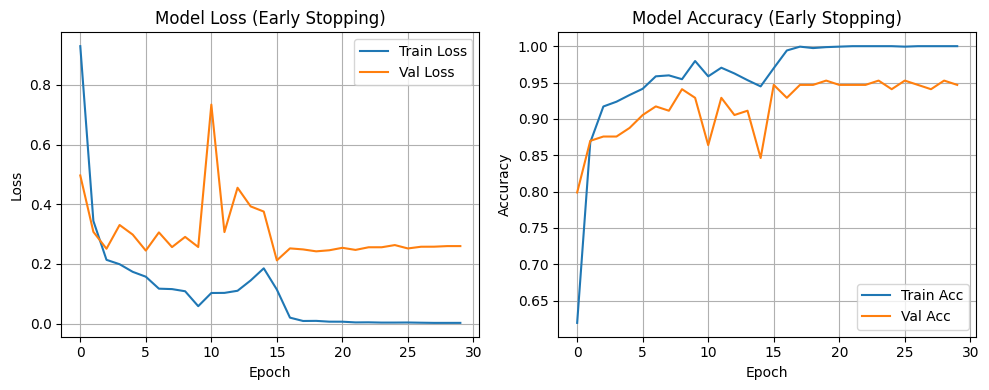

In [19]:
# Example 2B: Visualize effects of Early Stopping (PyTorch Version)

import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(ob_history['loss'], label='Train Loss')
ax1.plot(ob_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Early Stopping)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(ob_history['accuracy'], label='Train Acc')
ax2.plot(ob_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Early Stopping)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image28C.png)

### **Analysis**

The two plots shown in the example above, reveal a well-managed training process with **EarlyStopping** effectively preventing **overfitting**. Here's a detailed interpretation:

#### **Loss Plot (Top)**
* **Training Loss (blue):** Decreases steadily and stabilizes, indicating consistent learning.
* **Validation Loss (orange):** Fluctuates slightly but also trends downward, suggesting the model is generalizing reasonably well.

#### **Accuracy Plot (Bottom)**
* **Training Accuracy (blue):** Rises quickly and stabilizes near 1.0, showing strong performance on training data.
* **Validation Accuracy (orange):** Also rises quickly and stabilizes close to training accuracy, indicating good generalization.

#### **EarlyStopping Behavior**
* **Patience** = 10, monitoring val_accuracy.
* Training stopped at **epoch 25**, meaning validation accuracy did not improve for 10 consecutive epochs.
* This early stop likely prevented the model from entering an overfitting regime, which is supported by the close alignment between training and validation metrics.

#### **Conclusion**
Your model appears to have reached its optimal performance around epoch 15-20, and **EarlyStopping** correctly halted training before overfitting could occur. This is a textbook example of how EarlyStopping can be used to maintain generalization while avoiding unnecessary training.

### **Exercise 2A: Neural Network Training: Overfitting Prevention with `EarlyStopping`**

In the cell below write the code to to implement EarlyStopping in a classification model called `hd_model`.

**Code Hints:**

1. Copy-and-paste your code from **`Exercise 1`** in the cell below.
2. Remove the **`#`** before the line
```text
callbacks=callbacks,
```
in Section 8️⃣  `Train model`

3. Change the variable `VERBOSE` to equal `2` instead of `0`.

In [20]:
# Insert your code for Exercise 2A here

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 2
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function for timing
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
hd_df = pd.read_csv("https://biologicslab.co/BIO1173/data/heart_disease.csv",
                    na_values=['NA','?'])

# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
hd_target_col = "RestingECG"
le = LabelEncoder()
hd_df[hd_target_col] = le.fit_transform(hd_df[hd_target_col])

hd_X = hd_df.drop(columns=[hd_target_col])
hd_y = hd_df[hd_target_col].astype('int32')

# ------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# ------------------------------------------------------------
# First split into train+val and test
hd_X_temp, hd_X_test, hd_y_temp, hd_y_test = train_test_split(
    hd_X, hd_y, test_size=0.2, random_state=42, stratify=hd_y)

# Then split train+val into train and val
hd_X_train, hd_X_val, hd_y_train, hd_y_val = train_test_split(
    hd_X_temp, hd_y_temp, test_size=0.1, random_state=42, stratify=hd_y_temp)

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------
categorical_cols = [c for c in hd_X.columns if hd_X[c].dtype == "object"]
numeric_cols     = [c for c in hd_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Convert data to correct numeric type (Numpy arrays)
hd_X_train_proc = preprocessor.fit_transform(hd_X_train).astype(np.float32)
hd_X_val_proc   = preprocessor.transform(hd_X_val).astype(np.float32)
hd_X_test_proc  = preprocessor.transform(hd_X_test).astype(np.float32)

hd_y_train = hd_y_train.to_numpy().astype(np.int32).reshape(-1)
hd_y_val   = hd_y_val.to_numpy().astype(np.int32).reshape(-1)
hd_y_test  = hd_y_test.to_numpy().astype(np.int32).reshape(-1)

# ------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# ------------------------------------------------------------
hd_X_train_t = torch.tensor(hd_X_train_proc).to(device)
hd_X_val_t   = torch.tensor(hd_X_val_proc).to(device)
hd_X_test_t  = torch.tensor(hd_X_test_proc).to(device)

hd_y_train_t = torch.tensor(hd_y_train, dtype=torch.long).to(device)
hd_y_val_t   = torch.tensor(hd_y_val, dtype=torch.long).to(device)
hd_y_test_t  = torch.tensor(hd_y_test, dtype=torch.long).to(device)

hd_train_dataset = TensorDataset(hd_X_train_t, hd_y_train_t)
hd_val_dataset   = TensorDataset(hd_X_val_t, hd_y_val_t)

hd_train_loader = DataLoader(hd_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
hd_val_loader   = DataLoader(hd_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------------------------------------------
# 7️⃣  Build Model, Optimizer & Scheduler
# ------------------------------------------------------------
n_classes = len(np.unique(hd_y_train))
input_dim = hd_X_train_proc.shape[1]

class HeartDiseaseNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HeartDiseaseNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

hd_model = HeartDiseaseNet(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(hd_model.parameters(), lr=LEARNING_RATE)

# ReduceLROnPlateau Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                 factor=0.5,
                                                 patience=int(PATIENCE/2))

# ------------------------------------------------------------
# 8️⃣  Train model with Early Stopping
# ------------------------------------------------------------
print(f"-----Training Starting for up to {EPOCHS} epochs --------------------------")
start_time = time.time()

hd_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

# Variables for Early Stopping
best_val_acc = 0.0
patience_counter = 0
checkpoint_path = "hd_best_classification_model.pth"

for epoch in range(EPOCHS):
    # --- Training Phase ---
    hd_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in hd_train_loader:
        optimizer.zero_grad()
        outputs = hd_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(hd_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    hd_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in hd_val_loader:
            outputs = hd_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(hd_val_loader)
    val_acc = correct / total

    # Update History
    hd_history['accuracy'].append(train_acc)
    hd_history['val_accuracy'].append(val_acc)
    hd_history['loss'].append(avg_train_loss)
    hd_history['val_loss'].append(avg_val_loss)

    # Step Scheduler (monitor val_accuracy)
    scheduler.step(val_acc)

    # Print Progress
    if VERBOSE > 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}")

    # --- Early Stopping & Checkpointing Logic ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 # Reset counter
        torch.save(hd_model.state_dict(), checkpoint_path) # Save Best Model
        if VERBOSE > 0:
            print(f"  -> Val Acc improved to {val_acc:.4f}. Model saved.")
    else:
        patience_counter += 1
        if VERBOSE > 0:
            print(f"  -> No improvement. Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training & Restore Best Weights
# ---------------------------------------------------------------------------
# Load the best weights back into the model
hd_model.load_state_dict(torch.load(checkpoint_path))
print("\nRestored best model weights.")

print(f"Training finished")
print("Best val accuracy:", max(hd_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using device: cpu
-----Training Starting for up to 100 epochs --------------------------
Epoch 1/100 - loss: 0.9695 - acc: 0.5788 - val_loss: 0.9201 - val_acc: 0.6081
  -> Val Acc improved to 0.6081. Model saved.
Epoch 2/100 - loss: 0.8935 - acc: 0.5985 - val_loss: 0.8910 - val_acc: 0.6081
  -> No improvement. Patience: 1/10
Epoch 3/100 - loss: 0.8480 - acc: 0.6167 - val_loss: 0.9751 - val_acc: 0.5946
  -> No improvement. Patience: 2/10
Epoch 4/100 - loss: 0.8382 - acc: 0.6182 - val_loss: 0.9458 - val_acc: 0.6351
  -> Val Acc improved to 0.6351. Model saved.
Epoch 5/100 - loss: 0.8422 - acc: 0.6227 - val_loss: 0.9126 - val_acc: 0.6351
  -> No improvement. Patience: 1/10
Epoch 6/100 - loss: 0.8136 - acc: 0.6303 - val_loss: 0.9756 - val_acc: 0.5811
  -> No improvement. Patience: 2/10
Epoch 7/100 - loss: 0.8214 - acc: 0.6227 - val_loss: 0.9673 - val_acc: 0.6081
  -> No improvement. Patience: 3/10
Epoch 8/100 - loss: 0.8104 - acc: 0.6227 - val_loss: 0.9825 - val_acc: 0.6216
  -> No improve

If the code is correct you should see something _similar_ to the last part of the output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image31C.png)

While the number of Epochs was set to `100` training terminated in this particular training run after the `17th` Epoch due to the `EarlyStopping` monitor.

### **Exercise 2B: Visualize Effects of `EarlyStopping`**

`Copy-and-paste` your code from **Exercise 1B`** into the cell below and run it.

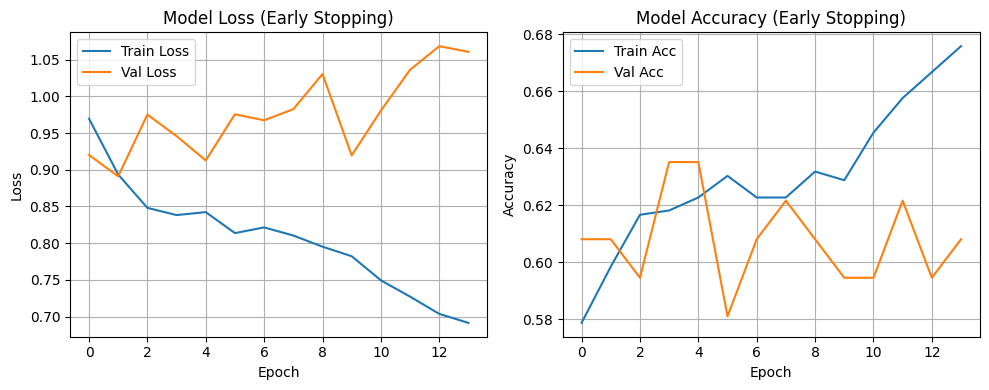

In [21]:
# Insert your code for Exercise 2B here

import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(hd_history['loss'], label='Train Loss')
ax1.plot(hd_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Early Stopping)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(hd_history['accuracy'], label='Train Acc')
ax2.plot(hd_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Early Stopping)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image30C.png)

### **Analysis**

The two plots shown in the example above, reveal a well-managed training process with **EarlyStopping** effectively preventing **overfitting**. Here's a detailed interpretation:

#### **Loss Plot (Top)**
* **Training Loss (blue):** Decreases gradually, indicating the model is learning from the training data. Starts off decreasing but then fluctuates and even slightly increases toward the end, suggesting the model may be starting to overfit.
* **Validation Loss (orange):** Also decreases initially but begins to fluctuate and slightly rise toward the end, suggesting the onset of overfitting.

#### **Accuracy Plot (Bottom)**
* **Training Accuracy (blue):**  Rises quickly and stabilizes near 1.0, showing strong performance on the training set.
* **Validation Accuracy (orange):** Increases initially and then plateaus, with no significant improvement after around epoch 7-8

#### **`EarlyStopping` Behavior**
* Since **val_accuracy** was monitored and **patience = 10**, the model stopped at **epoch 17** because validation accuracy did not improve for 10 consecutive epochs.
* This suggests the model reached its peak generalization performance early, and further training would not have improved validation results.

#### **Conclusion**
* The model was starting to overfit, and EarlyStopping correctly halted training before validation errors would have started to increase.


In the PyTorch ecosystem, "workers" (researchers and engineers) typically rely on three specific strategies to prevent overfitting. These are preferred because they are optimized, idiomatic, and easy to implement.

The 3 Standard PyTorch Strategies
Weight Decay (L2 Regularization)

Concept: This is the PyTorch equivalent of L2 Regularization. Instead of adding a penalty term manually in the loop, you tell the Optimizer to decay the weights.

Implementation: It is a single parameter passed to the optimizer.

Code: optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

Verdict: This is the most common way to add "penalty-based" regularization.

Dropout

Concept: Randomly "killing" (zeroing out) a percentage of neurons during training to prevent them from co-adapting too closely.

Implementation: You add a nn.Dropout() layer into your model architecture.

Code: self.dropout = nn.Dropout(0.5) in __init__.

Verdict: This is the most common "architectural" strategy.

Batch Normalization

Concept: Normalizes the inputs to each layer. While primarily for speed and stability, it has a strong regularization side-effect.

Implementation: self.bn = nn.BatchNorm1d(num_features) in __init__.

# **Drop Out for Keras to Decrease Overfitting**

Hinton, Srivastava, Krizhevsky, Sutskever, & Salakhutdinov (2012) introduced the **_dropout regularization_** algorithm. [[Cite:srivastava2014dropout]](http://www.jmlr.org/papers/volume15/nandan14a/nandan14a.pdf)

Although `dropout` works differently than `L1` and `L2`, it accomplishes the same goal—the prevention of **overfitting**. However, the algorithm does the task by actually **_removing_**  neurons and connections—at least temporarily. Unlike `L1` and `L2`, no weight penalty is added. `Dropout` does not directly seek to train small weights.

`Dropout` works by causing hidden neurons of the neural network to be unavailable during part of the training. Dropping part of the neural network causes the remaining portion to be trained to still achieve a good score even without the dropped neurons. This technique decreases co-adaptation between neurons, which results in less overfitting.

Most neural network frameworks implement `dropout` as a separate layer. `Dropout layers` function like a regular, densely connected neural network layer. The only difference is that the `dropout layers` will periodically drop some of their neurons during training. You can use dropout layers on regular feedforward neural networks.

A _program_ can implement a `dropout layer` as a dense layer that can eliminate some of its neurons. Contrary to popular belief about the `dropout layer`, such a program does not permanently remove these discarded neurons. In other words, a dropout layer does **_not_** lose any of its neurons during the training process, and it will still have the same number of neurons after training. In this way, the program only _temporarily masks_ the neurons rather than dropping them.

This figure shows how a dropout layer might be situated with other layers.


![Dropout Regularization](https://biologicslab.co/BIO1173/images/class_02/class_9_dropout.png "Dropout Regularization")

**Figure 5.DROPOUT: Dropout Regularization**

The discarded neurons and their connections are shown as dashed lines. The input layer has two input neurons as well as a bias neuron. The second layer is a dense layer with three neurons and a bias neuron. The third layer is a dropout layer with six regular neurons even though the program has dropped 50% of them.

While the program drops these neurons, it neither calculates nor trains them. However, the final neural network will use _all_ of these neurons for the output. As previously mentioned, the program only temporarily discards the neurons.

The program chooses different sets of neurons from the dropout layer during subsequent training iterations. Although we chose a probability of 50% for dropout, the computer will not necessarily drop three neurons. It is as if we flipped a coin for each of the dropout candidate neurons to choose if that neuron was dropped out. You must know that the program should never drop the bias neuron. Only the regular neurons on a dropout layer are candidates.

The implementation of the training algorithm influences the process of discarding neurons. The dropout set frequently changes once per training iteration or batch. The program can also provide intervals where all neurons are present. Some neural network frameworks give additional hyper-parameters to allow you to specify exactly the rate of this interval.

----------------------------------

## **Why does Dropout work?**

Why dropout is capable of decreasing overfitting is a common question. The answer is that dropout can reduce the chance of **codependency** developing between two neurons. Two neurons that develop codependency will not be able to operate effectively when one is dropped out. As a result, the neural network can no longer rely on the presence of every neuron, and it trains accordingly. This characteristic decreases its ability to memorize the information presented, thereby forcing generalization.

Dropout also decreases overfitting by **forcing a bootstrapping process** upon the neural network. Bootstrapping is a prevalent ensemble technique. Ensembling is a technique of machine learning that combines multiple models to produce a better result than those achieved by individual models. The ensemble is a term that originates from the musical ensembles in which the final music product that the audience hears is the combination of many instruments.  

**Bootstrapping** is one of the most simple ensemble techniques. The bootstrapping programmer simply trains several neural networks to perform precisely the same task. However, each neural network will perform differently because of some training techniques and the random numbers used in the neural network weight initialization. The difference in weights causes the performance variance. The output from this ensemble of neural networks becomes the average output of the members taken together. This process decreases overfitting through the consensus of differently trained neural networks.  

Dropout works somewhat like bootstrapping. You might think of each neural network that results from a different set of neurons being dropped out as an individual member in an ensemble. As training progresses, the program creates more neural networks in this way. However, dropout does not require the same amount of processing as bootstrapping. The new neural networks created are temporary; they exist only for a training iteration. The final result is also a single neural network rather than an ensemble of neural networks to be averaged together.

This short `YouTube` video shows how dropout works: [Dropout tutorial](https://youtu.be/NhZVe50QwPM?si=Zr-6qrPdE9YXTj3Q)

------------------------

### Example 3A: Neural Network Training: Overfitting Prevention with `L1 Regularization`

The code in the cell below is an **exact** copy of the code in `Example 1` except for the following modifications:

1. The code for building the neural network:
```text
# Build model
ob_model = models.Sequential([
    layers.Input(shape=(ob_X_train_proc.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])
```
has been modifed to include `L1 regularization` as follows:
```text
ob_model = models.Sequential([
    layers.Input(shape=(ob_X_train_proc.shape[1],)),
    layers.Dense(32, activation="relu",
                 kernel_regularizer=regularizers.l1(l1_reg)),
    layers.Dense(n_classes, activation="softmax")  # no regularizer on output
])

```
Where the strength of the `L1` was set by this line of code added to the end of Section 1️⃣  `Parameters`
```text
# L1 regularization strength
l1_reg = 1e-4          # <-- you can change this
```


In [23]:
# Example 3A: Overfitting Prevention with Dropout (PyTorch Standard Practice)

# -------------------------------------------------------------------
# 0️⃣  Imports
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------------------------------------------------
# 1️⃣  Parameters
# -------------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 0
LEARNING_RATE = 0.05
BATCH_SIZE    = 32
DROPOUT_RATE  = 0.5   # <--- New Parameter: Probability of zeroing a neuron

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function for timing
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# -------------------------------------------------------------------
# 2️⃣  Load data
# -------------------------------------------------------------------
ob_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
    na_values=['NA','?']
)

# -------------------------------------------------------------------
# 3️⃣  Target (Y-values)
# -------------------------------------------------------------------
ob_target_col = "NObeyesdad"
le = LabelEncoder()
ob_df[ob_target_col] = le.fit_transform(ob_df[ob_target_col])

ob_X = ob_df.drop(columns=[ob_target_col])
ob_y = ob_df[ob_target_col].astype('int32')

# -------------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# -------------------------------------------------------------------
ob_X_temp, ob_X_test, ob_y_temp, ob_y_test = train_test_split(
    ob_X, ob_y, test_size=0.2, random_state=42, stratify=ob_y
)

ob_X_train, ob_X_val, ob_y_train, ob_y_val = train_test_split(
    ob_X_temp, ob_y_temp, test_size=0.1, random_state=42, stratify=ob_y_temp
)

# -------------------------------------------------------------------
# 5️⃣  Preprocessing
# -------------------------------------------------------------------
categorical_cols = [c for c in ob_X.columns if ob_X[c].dtype == "object"]
numeric_cols     = [c for c in ob_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Fit & transform training data
ob_X_train_proc = preprocessor.fit_transform(ob_X_train).astype(np.float32)
ob_X_val_proc   = preprocessor.transform(ob_X_val).astype(np.float32)
ob_X_test_proc  = preprocessor.transform(ob_X_test).astype(np.float32)

ob_y_train = ob_y_train.to_numpy().astype(np.int32).reshape(-1)
ob_y_val   = ob_y_val.to_numpy().astype(np.int32).reshape(-1)
ob_y_test  = ob_y_test.to_numpy().astype(np.int32).reshape(-1)

# -------------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# -------------------------------------------------------------------
ob_X_train_t = torch.tensor(ob_X_train_proc).to(device)
ob_X_val_t   = torch.tensor(ob_X_val_proc).to(device)
ob_X_test_t  = torch.tensor(ob_X_test_proc).to(device)

ob_y_train_t = torch.tensor(ob_y_train, dtype=torch.long).to(device)
ob_y_val_t   = torch.tensor(ob_y_val, dtype=torch.long).to(device)
ob_y_test_t  = torch.tensor(ob_y_test, dtype=torch.long).to(device)

ob_train_dataset = TensorDataset(ob_X_train_t, ob_y_train_t)
ob_val_dataset   = TensorDataset(ob_X_val_t, ob_y_val_t)

ob_train_loader = DataLoader(ob_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ob_val_loader   = DataLoader(ob_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------------
# 7️⃣  Build Model with Dropout (Standard PyTorch Practice)
# -------------------------------------------------------------------
n_classes = len(np.unique(ob_y_train))
input_dim = ob_X_train_proc.shape[1]

class ObesityNetDropout(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNetDropout, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        # Dropout Layer: Randomly zeroes some elements of the input tensor
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)  # Apply Dropout after activation
        x = self.output(x)
        return x

ob_model = ObesityNetDropout(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ob_model.parameters(), lr=LEARNING_RATE)

# -------------------------------------------------------------------
# 8️⃣  Train model (Standard Loop - No Manual L1 Math needed)
# -------------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

ob_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    ob_model.train() # Important: Enables Dropout
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in ob_train_loader:
        optimizer.zero_grad()
        outputs = ob_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(ob_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    ob_model.eval() # Important: Disables Dropout (uses full network)
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in ob_val_loader:
            outputs = ob_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(ob_val_loader)
    val_acc = correct / total

    # Store metrics
    ob_history['accuracy'].append(train_acc)
    ob_history['val_accuracy'].append(val_acc)
    ob_history['loss'].append(avg_train_loss)
    ob_history['val_loss'].append(avg_val_loss)

    if VERBOSE == 1:
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}")

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(ob_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.9526627218934911
Elapsed time: 0:00:07.94


If the code is correct you should see something _similar_ to the last part of the output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image33C.png)

### Example 3B: Visualize Effects of Dropout

The code in the cell below is **exactly** the same as that used in `Example 1B`.

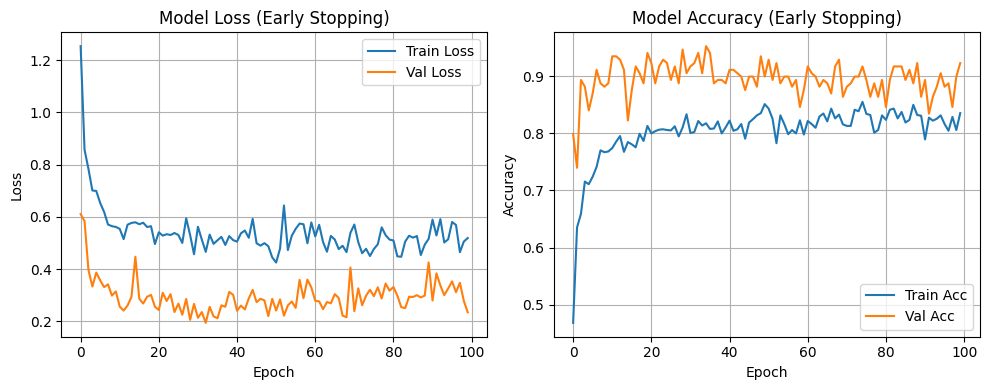

In [24]:
# Example 3B: Visualize effects of Dropout

import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(ob_history['loss'], label='Train Loss')
ax1.plot(ob_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Early Stopping)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(ob_history['accuracy'], label='Train Acc')
ax2.plot(ob_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Early Stopping)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image34C.png)

### **Analysis**

The two example plots shown above reflect the training dynamics of a neural network that used **L1 regularization** as its sole method for overfitting prevention. Here's a detailed interpretation:

#### **Loss Plot (Top)**
* **Training Loss (blue):** Decreases steadily, showing that the model is learning from the training data.
* **Validation Loss (orange):** Initially decreases but then begins to fluctuate and slightly rise, indicating the model may be starting to overfit or that validation performance is unstable.

#### **Accuracy Plot (Bottom)**
* **Training Accuracy (blue):** Rises quickly and stabilizes near 1.0, suggesting strong performance on the training set.
* **Validation Accuracy (orange):** Increases initially but plateaus and shows minimal improvement after around epoch 7-8.

#### **Impact of L1 Regularization**
* **L1 regularization** encourages sparsity in the model weights, which can help reduce overfitting by simplifying the model.
* However, the relatively small regularization strength (l1_reg = 1e-4) may not have been strong enough to fully prevent overfitting, as indicated by the divergence between training and validation metrics toward the end.

#### **Conclusion**
* The model learned effectively but began to show signs of overfitting or stagnation in validation performance.


### **Exercise 3A: Neural Network Training: Overfitting Prevention with Dropout**

In the cell below write the code to add `Dropout` to your `hd_model`.

**Code Hints:**

1. In the cell below `copy-and-paste` your **`Exercise 1A`** into the cell below. (Do **not** use **Exercise 2A`**).


In [25]:
# Insert your code for Exercise 3A here

# Exercise 3A: Overfitting Prevention with Dropout (Heart Disease)

# -------------------------------------------------------------------
# 0️⃣  Imports
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------------------------------------------------
# 1️⃣  Parameters
# -------------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 0
LEARNING_RATE = 0.05
BATCH_SIZE    = 32
DROPOUT_RATE  = 0.5   # <--- Probability of zeroing a neuron

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function for timing
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# -------------------------------------------------------------------
# 2️⃣  Load data
# -------------------------------------------------------------------
hd_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/heart_disease.csv",
    na_values=['NA','?']
)

# -------------------------------------------------------------------
# 3️⃣  Target (Y-values)
# -------------------------------------------------------------------
hd_target_col = "RestingECG"
le = LabelEncoder()
hd_df[hd_target_col] = le.fit_transform(hd_df[hd_target_col])

hd_X = hd_df.drop(columns=[hd_target_col])
hd_y = hd_df[hd_target_col].astype('int32')

# -------------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# -------------------------------------------------------------------
hd_X_temp, hd_X_test, hd_y_temp, hd_y_test = train_test_split(
    hd_X, hd_y, test_size=0.2, random_state=42, stratify=hd_y
)

hd_X_train, hd_X_val, hd_y_train, hd_y_val = train_test_split(
    hd_X_temp, hd_y_temp, test_size=0.1, random_state=42, stratify=hd_y_temp
)

# -------------------------------------------------------------------
# 5️⃣  Preprocessing
# -------------------------------------------------------------------
categorical_cols = [c for c in hd_X.columns if hd_X[c].dtype == "object"]
numeric_cols     = [c for c in hd_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Fit & transform training data
hd_X_train_proc = preprocessor.fit_transform(hd_X_train).astype(np.float32)
hd_X_val_proc   = preprocessor.transform(hd_X_val).astype(np.float32)
hd_X_test_proc  = preprocessor.transform(hd_X_test).astype(np.float32)

hd_y_train = hd_y_train.to_numpy().astype(np.int32).reshape(-1)
hd_y_val   = hd_y_val.to_numpy().astype(np.int32).reshape(-1)
hd_y_test  = hd_y_test.to_numpy().astype(np.int32).reshape(-1)

# -------------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# -------------------------------------------------------------------
hd_X_train_t = torch.tensor(hd_X_train_proc).to(device)
hd_X_val_t   = torch.tensor(hd_X_val_proc).to(device)
hd_X_test_t  = torch.tensor(hd_X_test_proc).to(device)

hd_y_train_t = torch.tensor(hd_y_train, dtype=torch.long).to(device)
hd_y_val_t   = torch.tensor(hd_y_val, dtype=torch.long).to(device)
hd_y_test_t  = torch.tensor(hd_y_test, dtype=torch.long).to(device)

hd_train_dataset = TensorDataset(hd_X_train_t, hd_y_train_t)
hd_val_dataset   = TensorDataset(hd_X_val_t, hd_y_val_t)

hd_train_loader = DataLoader(hd_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
hd_val_loader   = DataLoader(hd_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------------
# 7️⃣  Build Model with Dropout
# -------------------------------------------------------------------
n_classes = len(np.unique(hd_y_train))
input_dim = hd_X_train_proc.shape[1]

class HeartDiseaseNetDropout(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HeartDiseaseNetDropout, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        # Dropout Layer
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)  # Apply Dropout after activation
        x = self.output(x)
        return x

hd_model = HeartDiseaseNetDropout(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(hd_model.parameters(), lr=LEARNING_RATE)

# -------------------------------------------------------------------
# 8️⃣  Train model
# -------------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

hd_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    hd_model.train() # Enable Dropout
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in hd_train_loader:
        optimizer.zero_grad()
        outputs = hd_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(hd_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    hd_model.eval() # Disable Dropout
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in hd_val_loader:
            outputs = hd_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(hd_val_loader)
    val_acc = correct / total

    # Store metrics
    hd_history['accuracy'].append(train_acc)
    hd_history['val_accuracy'].append(val_acc)
    hd_history['loss'].append(avg_train_loss)
    hd_history['val_loss'].append(avg_val_loss)

    if VERBOSE == 1:
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}")

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(hd_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6486486486486487
Elapsed time: 0:00:03.08


If the code is correct you should see something _similar_ to the last part of the output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image35C.png)

### **Exercise 3B: Visualize Effects of Dropout**

`Copy-and-paste` the code from **`Exercise 1B`** into the cell below.

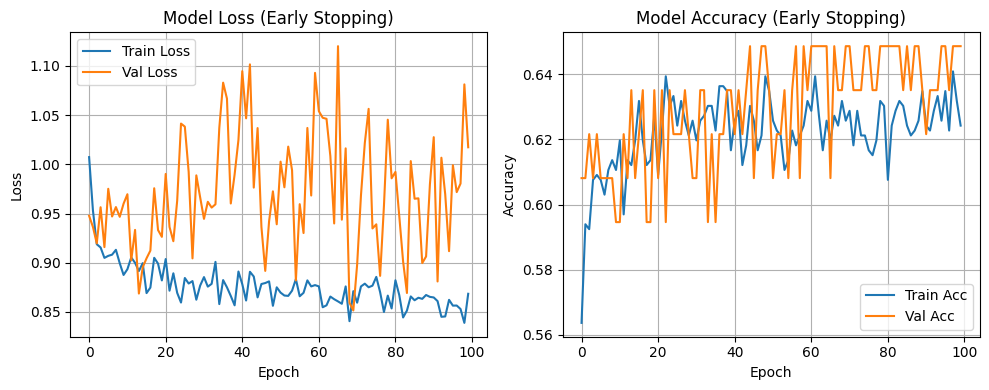

In [26]:
# Insert your code for Exercise 3B here

import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(hd_history['loss'], label='Train Loss')
ax1.plot(hd_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Dropout)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(hd_history['accuracy'], label='Train Acc')
ax2.plot(hd_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Dropout)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to this plot.

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image36C.png)

### **Analysis**

The two example plots shown above, that came from a training run with **L1 regularization**, show clear signs of **overfitting** and **limited generalization**. Here's a detailed analysis:

#### **Loss Plot (Top)**
* **Training Loss (blue):** Decreases gradually, indicating the model is learning the training data.
* **Validation Loss (orange):** Increases significantly over time, which is a strong indicator of overfitting. The model is fitting the training data well but failing to generalize to unseen data.

#### **Accuracy Plot (Bottom)**
* **Training Accuracy (blue):** Rises steadily and reaches around 0.80, showing decent performance on the training set.
* **Validation Accuracy (orange):** Fluctuates between 0.55 and 0.65, with no clear upward trend. This suggests the model is not improving on validation data and may be memorizing training patterns.


#### **Interpretation**
**L1 regularization alone** (especially with a modest strength like 1e-4) is **not sufficient** to prevent overfitting in this case.
* The absence of **EarlyStopping** allowed training to continue even as validation performance worsened.
* The lack of **Dropout layers** means the model may be relying too heavily on specific neurons, further contributing to overfitting.

# **L2 Regularization to Decrease Overfitting**

`L2 regularization` are two common regularization techniques that can reduce the effects of overfitting [[Cite:ng2004feature]](http://cseweb.ucsd.edu/~elkan/254spring05/Hammon.pdf). These algorithms can either work with an objective function or as a part of the backpropagation algorithm. In both cases, the regularization algorithm is attached to the training algorithm by adding an objective.

## **L1 Regularization**
In the context of a neural network with `L1 regularization`, the objective function typically consists of two main components: the `original loss function` and the `L1 regularization term`. The objective function serves as a measure that the optimization algorithm aims to minimize during the training process.

The objective function with `L1 regularization` can be represented as:
```text
Objective function = Loss function + λ * L1 regularization term
```
where:

* **Loss function:** The original loss function used to evaluate the performance of the neural network on the training data, such as the cross-entropy loss or mean squared error.
* **λ (lambda):** The regularization parameter that controls the strength of the L1 regularization penalty.
* **L1 regularization term:** The sum of absolute values of the weights in the neural network.

The addition of the `L1 regularization` term to the objective function encourages sparsity in the weights of the neural network by penalizing large weights. This helps prevent **overfitting** and can lead to a simpler and more interpretable model. The trade-off between minimizing the loss function and reducing the magnitude of the weights is controlled by the regularization parameter λ.

During the training process, the neural network adjusts its weights by minimizing the composite objective function, striking a balance between fitting the training data well (minimizing the loss function) and reducing model complexity (`L1 regularization`).

These algorithms work by adding a **weight penalty** to the neural network training. This **penalty** encourages the neural network to keep the weights to small values. Both `L1` and `L2` calculate this penalty differently. You can add this penalty calculation to the calculated gradients for gradient-descent-based algorithms, such as backpropagation. The penalty is negatively combined with the objective score for objective-function-based training, such as simulated annealing.


## **`L1` vs`L2` Regularization**
Both `L1` and `L2` work similarily in that they penalize the size of the weight, but in significantly different ways. `L2` will force the weights into a pattern similar to a `Gaussian distribution` while the `L1` will force the weights into a pattern similar to a `Laplace distribution`, as demonstrated in the following figure.

![L1 vs L2](https://biologicslab.co/BIO1173/images/class_9_l1_l2.png "L1 vs L2")

As you can see, the `L1 algorithm` is more tolerant of weights further from `0`, whereas the `L2 algorithm` is less tolerant.

### Example 4A: Neural Network Training: Overfitting Prevention with L2 Regularization.

The code in the cell below is an **exact** copy of the code in `Example 1` except for the following modification:

1. The code for building the neural network:
```text
# Build model
ob_model = models.Sequential([
    layers.Input(shape=(ob_X_train_proc.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])
```
has been modifed to include `Dropout` layers as follows:
```text
# Build model
ob_model = models.Sequential([
    layers.Input(shape=(ob_X_train_proc.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),  # Dropout after first dense layer
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),  # Dropout after second dense layer
    layers.Dense(n_classes, activation="softmax")
])

```



In [29]:
# Example 4A: Overfitting Prevention with L2 Regularization (Weight Decay)

# -------------------------------------------------------------------
# 0️⃣  Imports
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------------------------------------------------
# 1️⃣  Parameters
# -------------------------------------------------------------------
EPOCHS        = 100
VERBOSE       = 0
LEARNING_RATE = 0.05
BATCH_SIZE    = 32
L2_REG        = 0.001  # <--- New Parameter: Weight Decay Strength

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function for timing
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# -------------------------------------------------------------------
# 2️⃣  Load data
# -------------------------------------------------------------------
ob_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
    na_values=['NA','?']
)

# -------------------------------------------------------------------
# 3️⃣  Target (Y-values)
# -------------------------------------------------------------------
ob_target_col = "NObeyesdad"
le = LabelEncoder()
ob_df[ob_target_col] = le.fit_transform(ob_df[ob_target_col])

ob_X = ob_df.drop(columns=[ob_target_col])
ob_y = ob_df[ob_target_col].astype('int32')

# -------------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# -------------------------------------------------------------------
ob_X_temp, ob_X_test, ob_y_temp, ob_y_test = train_test_split(
    ob_X, ob_y, test_size=0.2, random_state=42, stratify=ob_y
)

ob_X_train, ob_X_val, ob_y_train, ob_y_val = train_test_split(
    ob_X_temp, ob_y_temp, test_size=0.1, random_state=42, stratify=ob_y_temp
)

# -------------------------------------------------------------------
# 5️⃣  Preprocessing
# -------------------------------------------------------------------
categorical_cols = [c for c in ob_X.columns if ob_X[c].dtype == "object"]
numeric_cols     = [c for c in ob_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Fit & transform training data
ob_X_train_proc = preprocessor.fit_transform(ob_X_train).astype(np.float32)
ob_X_val_proc   = preprocessor.transform(ob_X_val).astype(np.float32)
ob_X_test_proc  = preprocessor.transform(ob_X_test).astype(np.float32)

ob_y_train = ob_y_train.to_numpy().astype(np.int32).reshape(-1)
ob_y_val   = ob_y_val.to_numpy().astype(np.int32).reshape(-1)
ob_y_test  = ob_y_test.to_numpy().astype(np.int32).reshape(-1)

# -------------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# -------------------------------------------------------------------
ob_X_train_t = torch.tensor(ob_X_train_proc).to(device)
ob_X_val_t   = torch.tensor(ob_X_val_proc).to(device)
ob_X_test_t  = torch.tensor(ob_X_test_proc).to(device)

ob_y_train_t = torch.tensor(ob_y_train, dtype=torch.long).to(device)
ob_y_val_t   = torch.tensor(ob_y_val, dtype=torch.long).to(device)
ob_y_test_t  = torch.tensor(ob_y_test, dtype=torch.long).to(device)

ob_train_dataset = TensorDataset(ob_X_train_t, ob_y_train_t)
ob_val_dataset   = TensorDataset(ob_X_val_t, ob_y_val_t)

ob_train_loader = DataLoader(ob_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ob_val_loader   = DataLoader(ob_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------------
# 7️⃣  Build Model (Standard)
# -------------------------------------------------------------------
n_classes = len(np.unique(ob_y_train))
input_dim = ob_X_train_proc.shape[1]

class ObesityNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        # No Dropout layer here, we are testing L2 specifically
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

ob_model = ObesityNet(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()

# IMPLEMENTING L2 REGULARIZATION HERE:
# 'weight_decay' applies L2 penalty to the parameters
optimizer = optim.Adam(ob_model.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=L2_REG)

# -------------------------------------------------------------------
# 8️⃣  Train model
# -------------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

ob_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    ob_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in ob_train_loader:
        optimizer.zero_grad()
        outputs = ob_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(ob_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    ob_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in ob_val_loader:
            outputs = ob_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(ob_val_loader)
    val_acc = correct / total

    # Store metrics
    ob_history['accuracy'].append(train_acc)
    ob_history['val_accuracy'].append(val_acc)
    ob_history['loss'].append(avg_train_loss)
    ob_history['val_loss'].append(avg_val_loss)

    if VERBOSE == 1:
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}")

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(ob_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.9585798816568047
Elapsed time: 0:00:07.48


If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image37C.png)

### Example 4B: Visualize Effects of `L2 Regularization`.

The code in the cell below is **exactly** the same as that used in `Example 1B`.

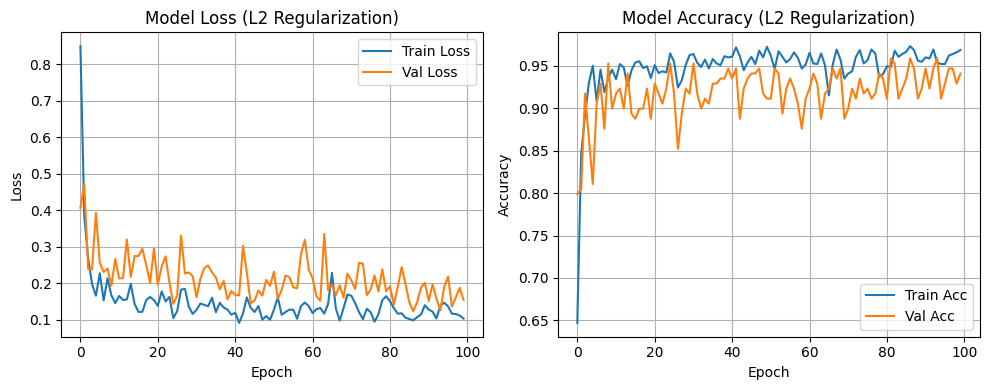

In [30]:
# Example 4B: Visualize effects of L2 Regularization

import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(ob_history['loss'], label='Train Loss')
ax1.plot(ob_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (L2 Regularization)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(ob_history['accuracy'], label='Train Acc')
ax2.plot(ob_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (L2 Regularization)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the top plot `With Dropout`.

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image38C.png)

### **Analysis**

These plots reflect the training dynamics of a neural network that used only **Dropout layers**. Here's a detailed analysis:

#### **Loss Plot (Top)**
* **Training Loss (blue):** Shows a general downward trend but with noticeable fluctuations, which is expected due to the **stochastic nature of Dropout**.
* **Validation Loss (orange)**: Also fluctuates significantly and does not show a consistent downward trend. It even appears to increase in later epochs, suggesting potential overfitting or instability.

* **Accuracy Plot (Bottom)**
* **Training Accuracy (blue):** Increases over time but with some variability, again consistent with Dropout's effect.
* **Validation Accuracy (orange):** Fluctuates throughout training and does not consistently improve, hovering between **0.5 and 0.75**, which is relatively low compared to training accuracy.

#### **Interpretation**
* **Dropout(( introduces randomness during training, which helps prevent overfitting by forcing the network to learn more robust features. However, without **EarlyStopping**, the model continues training even when validation performance stagnates or worsens.
* The absence of **L1 regularization** means there's no additional penalty for model complexity, which could allow the network to overfit despite Dropout.
* The **fluctuations** in validation metrics suggest that the model might benefit from:
* * **EarlyStopping** to halt training when validation accuracy stops improving.
* * **Tuning** the dropout rate (e.g., trying 0.2 or 0.4 instead of 0.3).
* * **Combining Dropout with L1 or L2 regularization** for more robust control over overfitting.

### **Exercise 4A: Neural Network Training: Overfitting Prevention with `L2 Regularization`**

In the cell below write the code to add `Dropout` layers to your `hd_model`.

**Code Hints:**

1. In the cell below `copy-and-paste` your **`Exercise 1A`** into the cell below. (Do **not** use **Exercise 2A`**).

2. Add `Dropout` layers by changing the building code from
```text
# Build model
hd_model = models.Sequential([
    layers.Input(shape=(hd_X_train_proc.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

```
> to the following:
```text
# Build model with dropout layers
hd_model = models.Sequential([
    layers.Input(shape=(hd_X_train_proc.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),  # Dropout after first dense layer
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),  # Dropout after second dense layer
    layers.Dense(n_classes, activation="softmax")
])
```

In [31]:
# Insert your code for Exercise 4A here
# Exercise 4A: Overfitting Prevention with L2 Regularization (Heart Disease)

# -------------------------------------------------------------------
# 0️⃣  Imports
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------------------------------------------------
# 1️⃣  Parameters
# -------------------------------------------------------------------
EPOCHS        = 100
VERBOSE       = 0
LEARNING_RATE = 0.05
BATCH_SIZE    = 32
L2_REG        = 0.001  # <--- Weight Decay Strength

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function for timing
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# -------------------------------------------------------------------
# 2️⃣  Load data
# -------------------------------------------------------------------
hd_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/heart_disease.csv",
    na_values=['NA','?']
)

# -------------------------------------------------------------------
# 3️⃣  Target (Y-values)
# -------------------------------------------------------------------
hd_target_col = "RestingECG"
le = LabelEncoder()
hd_df[hd_target_col] = le.fit_transform(hd_df[hd_target_col])

hd_X = hd_df.drop(columns=[hd_target_col])
hd_y = hd_df[hd_target_col].astype('int32')

# -------------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# -------------------------------------------------------------------
hd_X_temp, hd_X_test, hd_y_temp, hd_y_test = train_test_split(
    hd_X, hd_y, test_size=0.2, random_state=42, stratify=hd_y
)

hd_X_train, hd_X_val, hd_y_train, hd_y_val = train_test_split(
    hd_X_temp, hd_y_temp, test_size=0.1, random_state=42, stratify=hd_y_temp
)

# -------------------------------------------------------------------
# 5️⃣  Preprocessing
# -------------------------------------------------------------------
categorical_cols = [c for c in hd_X.columns if hd_X[c].dtype == "object"]
numeric_cols     = [c for c in hd_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Fit & transform training data
hd_X_train_proc = preprocessor.fit_transform(hd_X_train).astype(np.float32)
hd_X_val_proc   = preprocessor.transform(hd_X_val).astype(np.float32)
hd_X_test_proc  = preprocessor.transform(hd_X_test).astype(np.float32)

hd_y_train = hd_y_train.to_numpy().astype(np.int32).reshape(-1)
hd_y_val   = hd_y_val.to_numpy().astype(np.int32).reshape(-1)
hd_y_test  = hd_y_test.to_numpy().astype(np.int32).reshape(-1)

# -------------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# -------------------------------------------------------------------
hd_X_train_t = torch.tensor(hd_X_train_proc).to(device)
hd_X_val_t   = torch.tensor(hd_X_val_proc).to(device)
hd_X_test_t  = torch.tensor(hd_X_test_proc).to(device)

hd_y_train_t = torch.tensor(hd_y_train, dtype=torch.long).to(device)
hd_y_val_t   = torch.tensor(hd_y_val, dtype=torch.long).to(device)
hd_y_test_t  = torch.tensor(hd_y_test, dtype=torch.long).to(device)

hd_train_dataset = TensorDataset(hd_X_train_t, hd_y_train_t)
hd_val_dataset   = TensorDataset(hd_X_val_t, hd_y_val_t)

hd_train_loader = DataLoader(hd_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
hd_val_loader   = DataLoader(hd_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------------
# 7️⃣  Build Model (Standard)
# -------------------------------------------------------------------
n_classes = len(np.unique(hd_y_train))
input_dim = hd_X_train_proc.shape[1]

class HeartDiseaseNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HeartDiseaseNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        # No Dropout here, we are relying on L2 Regularization in the optimizer
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

hd_model = HeartDiseaseNet(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()

# IMPLEMENTING L2 REGULARIZATION HERE:
# 'weight_decay' applies L2 penalty to the parameters
optimizer = optim.Adam(hd_model.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=L2_REG)

# -------------------------------------------------------------------
# 8️⃣  Train model
# -------------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

hd_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    hd_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in hd_train_loader:
        optimizer.zero_grad()
        outputs = hd_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(hd_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    hd_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in hd_val_loader:
            outputs = hd_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(hd_val_loader)
    val_acc = correct / total

    # Store metrics
    hd_history['accuracy'].append(train_acc)
    hd_history['val_accuracy'].append(val_acc)
    hd_history['loss'].append(avg_train_loss)
    hd_history['val_loss'].append(avg_val_loss)

    if VERBOSE == 1:
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}")

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(hd_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6486486486486487
Elapsed time: 0:00:03.58


If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image39C.png)

### **Exercise 4B: Visualize Effects of `L2 Regularization`**

`Copy-and-paste` the code from **`Exercise 1B`** into the cell below.

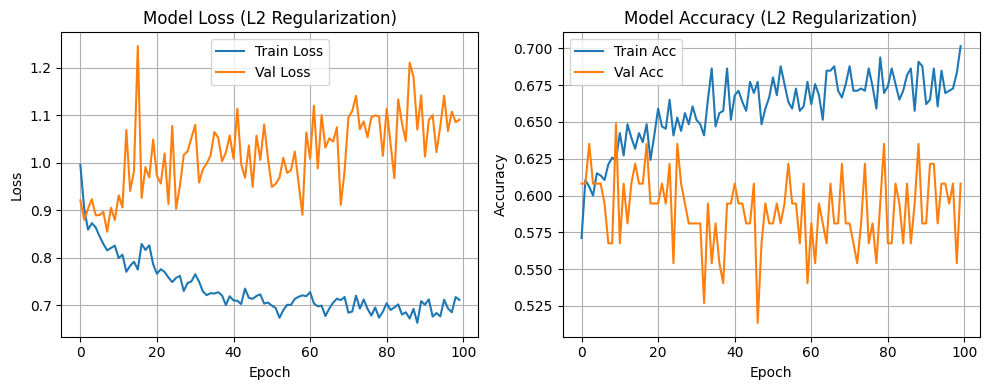

In [32]:
# Insert your code for Exercise 4B here

import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(hd_history['loss'], label='Train Loss')
ax1.plot(hd_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (L2 Regularization)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(hd_history['accuracy'], label='Train Acc')
ax2.plot(hd_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (L2 Regularization)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image40C.png)

### **Analysis**

The training run, shown in the examples above, used **`Dropout`** layers for regularization. In this instance we have a model that **struggled to learn effectively**. Here's a detailed analysis:

#### **Loss Plot (Top)**
* **Training Loss (blue):** Fluctuates but trends slightly downward, indicating some learning.
* **Validation Loss (orange):** Shows significant spikes and instability, suggesting inconsistent generalization and possibly poor convergence.

#### **Accuracy Plot (Bottom)**
* **Training Accuracy (blue):** Starts low and increases gradually, stabilizing around **0.59-0.60**, which is relatively modest.
* **Validation Accuracy (orange):** Drops early and then remains flat around **0.60**, showing little improvement over time.

#### **Interpretation**
* The model is **underfitting**: both training and validation accuracy are low and close to each other, which suggests the model hasn't captured the underlying patterns in the data well.
* **Dropout alone**, especially at a rate of 0.3 in multiple layers, may be too aggressive for this architecture or dataset, preventing the model from learning effectively.
* The absence of **EarlyStopping** means training continued despite stagnation in validation performance.
* The lack of **L1 regularization** means there's no penalty for complexity, but in this case, the model isn't even reaching high complexity—it’s just not learning well.

### **Recommendations**
To improve performance:

* * **Reduce the dropout rate** (e.g., from 0.3 to 0.2 or 0.1).
* * **Add EarlyStopping** to avoid wasting epochs once validation accuracy plateaus.
* * Consider adding **L1 or L2 regularization** to complement Dropout.
* * **Increase model capacity** slightly (e.g., more neurons or layers) if underfitting persists.

### Example 5: Batch

In [39]:
# Example 5A: Overfitting Prevention with Batch Normalization (PyTorch Version)

# -------------------------------------------------------------------
# 0️⃣  Imports
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------------------------------------------------
# 1️⃣  Parameters
# -------------------------------------------------------------------
EPOCHS        = 100
VERBOSE       = 0
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function for timing
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# -------------------------------------------------------------------
# 2️⃣  Load data
# -------------------------------------------------------------------
ob_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
    na_values=['NA','?']
)

# -------------------------------------------------------------------
# 3️⃣  Target (Y-values)
# -------------------------------------------------------------------
ob_target_col = "NObeyesdad"
le = LabelEncoder()
ob_df[ob_target_col] = le.fit_transform(ob_df[ob_target_col])

ob_X = ob_df.drop(columns=[ob_target_col])
ob_y = ob_df[ob_target_col].astype('int32')

# -------------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# -------------------------------------------------------------------
ob_X_temp, ob_X_test, ob_y_temp, ob_y_test = train_test_split(
    ob_X, ob_y, test_size=0.2, random_state=42, stratify=ob_y
)

ob_X_train, ob_X_val, ob_y_train, ob_y_val = train_test_split(
    ob_X_temp, ob_y_temp, test_size=0.1, random_state=42, stratify=ob_y_temp
)

# -------------------------------------------------------------------
# 5️⃣  Preprocessing
# -------------------------------------------------------------------
categorical_cols = [c for c in ob_X.columns if ob_X[c].dtype == "object"]
numeric_cols     = [c for c in ob_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Fit & transform training data
ob_X_train_proc = preprocessor.fit_transform(ob_X_train).astype(np.float32)
ob_X_val_proc   = preprocessor.transform(ob_X_val).astype(np.float32)
ob_X_test_proc  = preprocessor.transform(ob_X_test).astype(np.float32)

ob_y_train = ob_y_train.to_numpy().astype(np.int32).reshape(-1)
ob_y_val   = ob_y_val.to_numpy().astype(np.int32).reshape(-1)
ob_y_test  = ob_y_test.to_numpy().astype(np.int32).reshape(-1)

# -------------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# -------------------------------------------------------------------
ob_X_train_t = torch.tensor(ob_X_train_proc).to(device)
ob_X_val_t   = torch.tensor(ob_X_val_proc).to(device)
ob_X_test_t  = torch.tensor(ob_X_test_proc).to(device)

ob_y_train_t = torch.tensor(ob_y_train, dtype=torch.long).to(device)
ob_y_val_t   = torch.tensor(ob_y_val, dtype=torch.long).to(device)
ob_y_test_t  = torch.tensor(ob_y_test, dtype=torch.long).to(device)

ob_train_dataset = TensorDataset(ob_X_train_t, ob_y_train_t)
ob_val_dataset   = TensorDataset(ob_X_val_t, ob_y_val_t)

ob_train_loader = DataLoader(ob_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ob_val_loader   = DataLoader(ob_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------------
# 7️⃣  Build Model with Batch Normalization
# -------------------------------------------------------------------
n_classes = len(np.unique(ob_y_train))
input_dim = ob_X_train_proc.shape[1]

class ObesityNetBN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNetBN, self).__init__()

        # Hidden Layer
        self.layer1 = nn.Linear(input_dim, 32)

        # Batch Norm Layer (32 features coming from layer1)
        # 1D is used for Dense/Linear layers
        self.bn1 = nn.BatchNorm1d(32)

        self.relu = nn.ReLU()

        # Output Layer
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        # Order: Linear -> BatchNorm -> ReLU
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.output(x)
        return x

ob_model = ObesityNetBN(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ob_model.parameters(), lr=LEARNING_RATE)

# -------------------------------------------------------------------
# 8️⃣  Train model
# -------------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

ob_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    # Important: ob_model.train() tells BN to use batch statistics
    ob_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in ob_train_loader:
        optimizer.zero_grad()
        outputs = ob_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(ob_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    # Important: ob_model.eval() tells BN to use running stats (not batch stats)
    ob_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in ob_val_loader:
            outputs = ob_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(ob_val_loader)
    val_acc = correct / total

    # Store metrics
    ob_history['accuracy'].append(train_acc)
    ob_history['val_accuracy'].append(val_acc)
    ob_history['loss'].append(avg_train_loss)
    ob_history['val_loss'].append(avg_val_loss)

    if VERBOSE == 1:
        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"loss: {avg_train_loss:.4f} - "
            f"acc: {train_acc:.4f} - "
            f"val_loss: {avg_val_loss:.4f} - "
            f"val_acc: {val_acc:.4f}"
        )
# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(ob_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using device: cpu
------Training Starting for 100 epochs --------------
Epoch 1/100 - loss: 0.9049 - acc: 0.6379 - val_loss: 0.4971 - val_acc: 0.7929
Epoch 2/100 - loss: 0.5730 - acc: 0.7729 - val_loss: 0.4161 - val_acc: 0.7988
Epoch 3/100 - loss: 0.4205 - acc: 0.8374 - val_loss: 0.4126 - val_acc: 0.8284
Epoch 4/100 - loss: 0.4376 - acc: 0.8223 - val_loss: 0.2814 - val_acc: 0.8994
Epoch 5/100 - loss: 0.3108 - acc: 0.8874 - val_loss: 0.3113 - val_acc: 0.8521
Epoch 6/100 - loss: 0.3193 - acc: 0.8782 - val_loss: 0.1883 - val_acc: 0.9527
Epoch 7/100 - loss: 0.3548 - acc: 0.8657 - val_loss: 0.2407 - val_acc: 0.9112
Epoch 8/100 - loss: 0.2907 - acc: 0.8874 - val_loss: 0.3046 - val_acc: 0.8521
Epoch 9/100 - loss: 0.3298 - acc: 0.8782 - val_loss: 0.2897 - val_acc: 0.8757
Epoch 10/100 - loss: 0.3616 - acc: 0.8644 - val_loss: 0.2730 - val_acc: 0.9172
Epoch 11/100 - loss: 0.2707 - acc: 0.9013 - val_loss: 0.2282 - val_acc: 0.9172
Epoch 12/100 - loss: 0.2960 - acc: 0.8927 - val_loss: 0.3172 - val_a

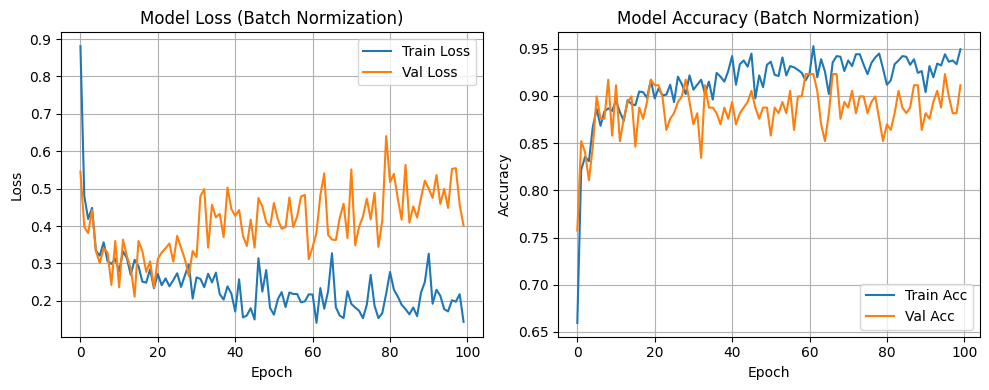

In [35]:
# Example 5B: Visualize effects of Batch Normalization

import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(ob_history['loss'], label='Train Loss')
ax1.plot(ob_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Batch Normization)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(ob_history['accuracy'], label='Train Acc')
ax2.plot(ob_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Batch Normization)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### **Exercise 5A: Batch Normalization**

In [36]:
# Exercise 5A: Overfitting Prevention with Batch Normalization (Heart Disease)

# -------------------------------------------------------------------
# 0️⃣  Imports
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------------------------------------------------
# 1️⃣  Parameters
# -------------------------------------------------------------------
EPOCHS        = 100
VERBOSE       = 0
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function for timing
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# -------------------------------------------------------------------
# 2️⃣  Load data
# -------------------------------------------------------------------
hd_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/heart_disease.csv",
    na_values=['NA','?']
)

# -------------------------------------------------------------------
# 3️⃣  Target (Y-values)
# -------------------------------------------------------------------
hd_target_col = "RestingECG"
le = LabelEncoder()
hd_df[hd_target_col] = le.fit_transform(hd_df[hd_target_col])

hd_X = hd_df.drop(columns=[hd_target_col])
hd_y = hd_df[hd_target_col].astype('int32')

# -------------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# -------------------------------------------------------------------
hd_X_temp, hd_X_test, hd_y_temp, hd_y_test = train_test_split(
    hd_X, hd_y, test_size=0.2, random_state=42, stratify=hd_y
)

hd_X_train, hd_X_val, hd_y_train, hd_y_val = train_test_split(
    hd_X_temp, hd_y_temp, test_size=0.1, random_state=42, stratify=hd_y_temp
)

# -------------------------------------------------------------------
# 5️⃣  Preprocessing
# -------------------------------------------------------------------
categorical_cols = [c for c in hd_X.columns if hd_X[c].dtype == "object"]
numeric_cols     = [c for c in hd_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Fit & transform training data
hd_X_train_proc = preprocessor.fit_transform(hd_X_train).astype(np.float32)
hd_X_val_proc   = preprocessor.transform(hd_X_val).astype(np.float32)
hd_X_test_proc  = preprocessor.transform(hd_X_test).astype(np.float32)

hd_y_train = hd_y_train.to_numpy().astype(np.int32).reshape(-1)
hd_y_val   = hd_y_val.to_numpy().astype(np.int32).reshape(-1)
hd_y_test  = hd_y_test.to_numpy().astype(np.int32).reshape(-1)

# -------------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# -------------------------------------------------------------------
hd_X_train_t = torch.tensor(hd_X_train_proc).to(device)
hd_X_val_t   = torch.tensor(hd_X_val_proc).to(device)
hd_X_test_t  = torch.tensor(hd_X_test_proc).to(device)

hd_y_train_t = torch.tensor(hd_y_train, dtype=torch.long).to(device)
hd_y_val_t   = torch.tensor(hd_y_val, dtype=torch.long).to(device)
hd_y_test_t  = torch.tensor(hd_y_test, dtype=torch.long).to(device)

hd_train_dataset = TensorDataset(hd_X_train_t, hd_y_train_t)
hd_val_dataset   = TensorDataset(hd_X_val_t, hd_y_val_t)

hd_train_loader = DataLoader(hd_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
hd_val_loader   = DataLoader(hd_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------------
# 7️⃣  Build Model with Batch Normalization
# -------------------------------------------------------------------
n_classes = len(np.unique(hd_y_train))
input_dim = hd_X_train_proc.shape[1]

class HeartDiseaseNetBN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HeartDiseaseNetBN, self).__init__()

        # Hidden Layer
        self.layer1 = nn.Linear(input_dim, 32)

        # Batch Norm Layer (32 features coming from layer1)
        self.bn1 = nn.BatchNorm1d(32)

        self.relu = nn.ReLU()

        # Output Layer
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        # Order: Linear -> BatchNorm -> ReLU
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.output(x)
        return x

hd_model = HeartDiseaseNetBN(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(hd_model.parameters(), lr=LEARNING_RATE)

# -------------------------------------------------------------------
# 8️⃣  Train model
# -------------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

hd_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    hd_model.train() # Important for BN
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in hd_train_loader:
        optimizer.zero_grad()
        outputs = hd_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(hd_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    hd_model.eval() # Important for BN
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in hd_val_loader:
            outputs = hd_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(hd_val_loader)
    val_acc = correct / total

    # Store metrics
    hd_history['accuracy'].append(train_acc)
    hd_history['val_accuracy'].append(val_acc)
    hd_history['loss'].append(avg_train_loss)
    hd_history['val_loss'].append(avg_val_loss)

    if VERBOSE == 1:
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}")

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(hd_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6621621621621622
Elapsed time: 0:00:03.35


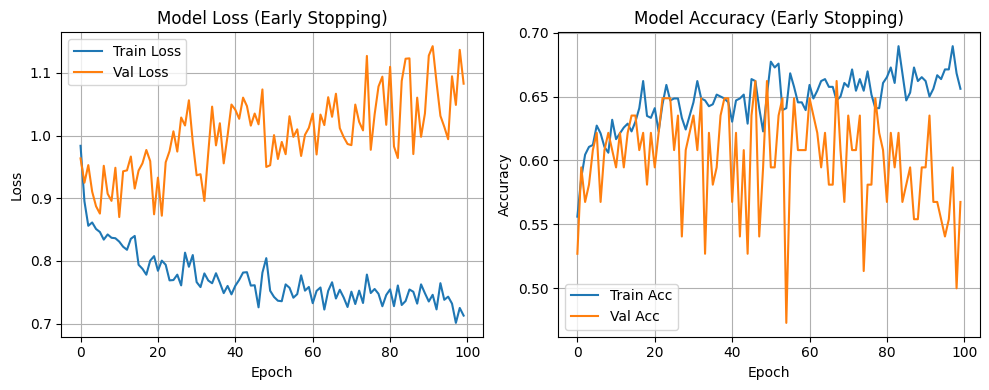

In [37]:
# Insert your code for Exercise 5B here

import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(hd_history['loss'], label='Train Loss')
ax1.plot(hd_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Batch Normalization)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(hd_history['accuracy'], label='Train Acc')
ax2.plot(hd_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Batch Normalization)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# **Lesson Turn-in**

When you have completed and run all of the code cells, use the **File --> Print.. --> Save to PDF** to generate a PDF of your Colab notebook. Save your PDF as `Class_02_3.lastname.pdf` where _lastname_ is your last name, and upload the file to Canvas. Make sure you submitted a COPY of this lesson that had been saved to your GDrive instead of the orignal Colab notebook if you want this lesson graded.

# **Lizard Tail**


![___](https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/Apple_II_typical_configuration_1977.png/2560px-Apple_II_typical_configuration_1977.png)

## **Apple II (original)**

The **Apple II** (stylized as apple ][) is a personal computer released by Apple Inc. in June 1977. It was one of the first successful mass-produced microcomputer products and is widely regarded as one of the most important personal computers of all time due to its role in popularizing home computing and influencing later software development.

The Apple II was designed primarily by Steve Wozniak. The system is based around the 8-bit MOS Technology 6502 microprocessor. Jerry Manock designed the foam-molded plastic case, Rod Holt developed the switching power supply, while Steve Jobs was not involved in the design of the computer. It was introduced by Jobs and Wozniak at the 1977 West Coast Computer Faire, and marks Apple's first launch of a computer aimed at a consumer market—branded toward American households rather than businessmen or computer hobbyists.


The three computers that Byte magazine referred to as the "1977 Trinity" of home computing: Commodore PET 2001, Apple II, and TRS-80 Model I
Byte magazine referred to the Apple II, Commodore PET 2001, and TRS-80 as the "1977 Trinity". As the Apple II had the defining feature of being able to display color graphics, the Apple logo was redesigned to have a spectrum of colors.

The Apple II was the first in a series of computers collectively referred to by the Apple II name. It was followed by the Apple II+, Apple IIe, Apple IIc, Apple IIc Plus, and the 16-bit Apple IIGS—all of which remained compatible. Production of the last available model, the Apple IIe, ceased in November 1993.

**History**

By 1976, Steve Jobs had convinced product designer Jerry Manock (who had formerly worked at Hewlett Packard designing calculators) to create the "shell" for the Apple II—a smooth case inspired by kitchen appliances that concealed the internal mechanics. The earliest Apple II computers were assembled in Silicon Valley and later in Texas; printed circuit boards were manufactured in Ireland and Singapore. The first computers went on sale on June 10, 1977 with an MOS Technology 6502 microprocessor running at 1.023 MHz (2⁄7 of the NTSC color subcarrier), two game paddles (bundled until 1980, when they were found to violate FCC regulations), 4 KiB of RAM, an audio cassette interface for loading programs and storing data, and the Integer BASIC programming language built into ROMs. The video controller displayed 24 lines by 40 columns of monochrome, uppercase-only text on the screen (the original character set matches ASCII characters 20h to 5Fh), with NTSC composite video output suitable for display on a video monitor or on a regular TV set (by way of a separate RF modulator).

The original retail price of the computer with 4 KiB of RAM was US \$1,298 (equivalent to \$6,530 in 2023) and with the maximum 48 KiB of RAM, it was US \$2,638 (equivalent to \$13,260 in 2023) To reflect the computer's color graphics capability, the Apple logo on the casing has rainbow stripes, which remained a part of Apple's corporate logo until early 1998. Perhaps most significantly, the Apple II was a catalyst for personal computers across many industries; it opened the doors to software marketed at consumers.

Certain aspects of the system's design were influenced by Atari, Inc.'s arcade video game Breakout (1976), which was designed by Wozniak, who said: "A lot of features of the Apple II went in because I had designed Breakout for Atari. I had designed it in hardware. I wanted to write it in software now". This included his design of color graphics circuitry, the addition of game paddle support and sound, and graphics commands in Integer BASIC, with which he wrote Brick Out, a software clone of his own hardware game. Wozniak said in 1984: "Basically, all the game features were put in just so I could show off the game I was familiar with—Breakout—at the Homebrew Computer Club. It was the most satisfying day of my life I demonstrated Breakout—totally written in BASIC. It seemed like a huge step to me. After designing hardware arcade games, I knew that being able to program them in BASIC was going to change the world."

# Summary of the Apple II Computer

## Introduction

The **Apple II**, introduced in **1977**, was one of the first highly successful mass-produced microcomputers. It was designed primarily by **Steve Wozniak**, with marketing and business strategy led by **Steve Jobs**. It played a crucial role in launching the personal computer revolution.

## Key Features

- **Processor**: MOS Technology 6502 @ 1 MHz
- **Memory**: 4 KB RAM (expandable to 48 KB)
- **Storage**: Cassette tape initially; later supported 5.25" floppy disks via the Disk II drive
- **Display**: Color graphics with text and low/high-resolution modes
- **Operating System**: Initially used Integer BASIC in ROM; later supported Apple DOS

## Innovations

- First personal computer with **color graphics**.
- Included **expansion slots**, allowing users to add peripherals and customize the system.
- Came fully assembled and ready to use, unlike many kit computers of the era.

## Impact

- Widely adopted in **education**, **business**, and **home computing**.
- Helped establish Apple as a major player in the tech industry.
- Spawned a long line of successors, including the Apple IIe and Apple IIGS.

## Legacy

The Apple II is remembered as a pioneering product that made computing accessible to the general public. Its success laid the foundation for Apple's future innovations and the broader personal computing industry.

# 🖥️ The Original Apple II (1977)

The **Apple II**, released in **June 1977**, was one of the first highly successful mass-produced microcomputers. Designed primarily by **Steve Wozniak**, it played a pivotal role in launching the personal computer revolution.

---

## 🔧 Key Specifications

FeatureDetailsCPUMOS Technology 6502 @ 1 MHz| **RAM**              | 4 KB (expandable up to 48 KB)                |
| **Storage**          | Cassette tape (initially), later floppy disk |
| **Display**          | Color graphics (up to 280×192 resolution)    |
| **Sound**            | Single-bit speaker                           |
| **Keyboard**         | Built-in QWERTY keyboard                     |
| **Expansion Slots**  | 8 internal slots for peripherals             |
| **Operating System** | Integer BASIC (in ROM), later Apple DOS      |

---

## 🎨 Graphics Capabilities

- Supported **color graphics**, a major innovation at the time.
- Text mode: 40×24 characters.
- Graphics modes: Low-res (40×48) and High-res (280×192).
- Could display up to **6 colors** in high-res mode.

---

## 💾 Storage Evolution

- Initially used **cassette tapes** for data storage.
- In 1978, Apple introduced the **Disk II** floppy drive, which dramatically improved speed and reliability.
- Apple DOS 3.1 was the first disk operating system for the Apple II.

---

## 🧠 Software Ecosystem

- Early programs included **VisiCalc**, the first spreadsheet software, which made the Apple II popular in business.
- Supported a wide range of educational, gaming, and productivity software.
- Programming languages: Integer BASIC, Applesoft BASIC, Pascal, and assembly.

---

## 🏛️ Historical Impact

- One of the first computers marketed to **individuals and schools**, not just hobbyists.
- Helped establish Apple as a major player in the tech industry.
- Remained in production (with upgrades) until **1993**.

---

## 📸 Fun Fact

The Apple II was famously used in the movie *WarGames* (1983), showcasing its cultural relevance.


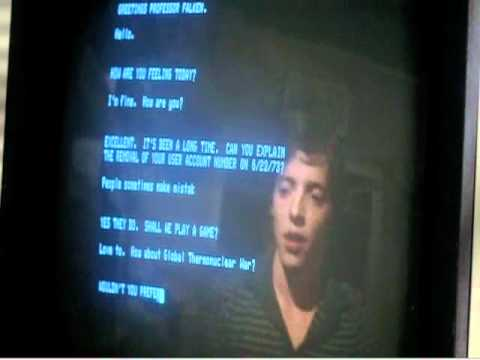

In [ ]:
from IPython.display import YouTubeVideo

# Embed the video using its ID
YouTubeVideo('-1F7vaNP9w0', width=800, height=450)
